# Table of Contents

* [Combine all data sources (Bureau balance dataset excluded)](#Combine-all-data-sources-(Bureau-balance-dataset-excluded))
    * [1. Remove duplicate SK_ID_CURR column](#1.-Remove-duplicate-SK_ID_CURR-column)
    * [2. Remove duplicate TOTAL_NUM_PREV_APPS column](#2.-Remove-duplicate-TOTAL_NUM_PREV_APPS-column)
    * [3. Remove duplicate SUM_DPD_DEF_GE0 column](#3.-Remove-duplicate-SUM_DPD_DEF_GE0-column)
    * [4. Save data to SQLite database](#4.-Save-data-to-SQLite-database)
* [Data cleaning, Exploratory Data Analysis and Transformation](#Data-cleaning,-Exploratory-Data-Analysis-and-Transformation)
    * [1. Import the combined dataset from SQLite Database](#1.-Import-the-combined-dataset-from-SQLite-Database)
    * [2. Check table details](#2.-Check-table-details)
    * [3. Remove columns with missing percent greater than 60%](#3.-Remove-columns-with-missing-percent-greater-than-60%)
    * [4. EDA and One hot encoding for categorical variables](#4.-EDA-and-One-hot-encoding-for-categorical-variables)
    * [5. Check this intermediate cleaned up table and save it in SQLite database](#5.-Check-this-intermediate-cleaned-up-table-and-save-it-in-SQLite-database)
    * [6. EDA for numeric variables](#6.-EDA-for-numeric-variables)
    * [7. Data transformation, high correlation column removal and outlier removal](#7.-Data-transformation,-high-correlation-column-removal-and-outlier-removal)
    * [8. Missing value imputations](#8.-Missing-value-imputations)
    * [9. Save the complete data into SQLite database](#9.-Save-the-complete-data-into-SQLite-database)

## Combine all data sources (Bureau balance dataset excluded)

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
%matplotlib inline  
import statistics
from scipy import stats
from scipy.stats import t
from scipy.stats import norm
import seaborn as sns
import sqlite3
from sqlite3 import Error
import csv

In [2]:
# open connection to sqlite database 
con = sqlite3.connect(r"pythonsqlite.db")
cur = con.cursor()

# combine all data sources:
sql_sm = '''SELECT A.*, B.*, C.*, D.*, E.*
            FROM app_bureau AS A
            LEFT JOIN
                prev_gp AS B ON A.SK_ID_CURR = B.SK_ID_CURR
            LEFT JOIN
                inst_pay_cur_gp AS C ON A.SK_ID_CURR = C.SK_ID_CURR
            LEFT JOIN
                pos_cur_gp AS D ON A.SK_ID_CURR = D.SK_ID_CURR
            LEFT JOIN
                card_bal_cur_gp AS E ON A.SK_ID_CURR = E.SK_ID_CURR
            '''
data_all = pd.read_sql(sql_sm, coerce_float=True, con=con)

display(data_all.head())
print(data_all.shape)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  AVG_AMT_RECEIVABLE_PRINCIPAL AVG_AMT_RECIVABLE  \
0  ...                           NaN               NaN   
1  ...                           NaN               NaN   
2  ...                           NaN               NaN   
3  ...                           0.0               0.0   
4  ...                           NaN               NaN   

  AVG_AMT_TOTAL_RECEIVABLE SUM_CNT_DRAWINGS_ATM_CURRENT  \
0                      NaN                          NaN   
1                      NaN                          NaN   
2                      NaN                          NaN   
3                      0.0                          NaN   
4                      NaN                          NaN   

  SUM_CNT_DRAWINGS_CURRENT SUM_CNT_DRAWINGS_OTHER_CURRENT  \
0                      NaN                            NaN   
1                      NaN                            NaN   
2                      NaN                            NaN   
3                      0.0                            NaN   
4                      NaN                            NaN   

   SUM_CNT_DRAWINGS_POS_CURRENT  SUM_CNT_INSTALMENT_MATURE_CUM  SUM_DPD_GE1  \
0                           NaN                            NaN          NaN   
1                           NaN                            NaN          NaN   
2                           NaN                            NaN          NaN   
3                           NaN                            0.0          0.0   
4                           NaN                            NaN          NaN   

   SUM_DPD_DEF_GE0  
0              NaN  
1              NaN  
2              NaN  
3              0.0  
4              NaN  

[5 rows x 339 columns]

(307511, 339)


## 1. Remove duplicate SK_ID_CURR column

In [3]:
data_all['SK_ID_CURR_2'] = 'A'
data_all['SK_ID_CURR_2'] = data_all['SK_ID_CURR'] 
data_all.drop(['SK_ID_CURR'], axis = 1, inplace = True)
data_all.rename(columns = {'SK_ID_CURR_2':'SK_ID_CURR'}, inplace = True)
display(data_all.head())
print(data_all.shape)

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0       1         Cash loans           M            N               Y   
1       0         Cash loans           F            N               N   
2       0    Revolving loans           M            Y               Y   
3       0         Cash loans           F            N               Y   
4       0         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ... AVG_AMT_RECIVABLE AVG_AMT_TOTAL_RECEIVABLE  \
0  ...               NaN                      NaN   
1  ...               NaN                      NaN   
2  ...               NaN                      NaN   
3  ...               0.0                      0.0   
4  ...               NaN                      NaN   

  SUM_CNT_DRAWINGS_ATM_CURRENT SUM_CNT_DRAWINGS_CURRENT  \
0                          NaN                      NaN   
1                          NaN                      NaN   
2                          NaN                      NaN   
3                          NaN                      0.0   
4                          NaN                      NaN   

  SUM_CNT_DRAWINGS_OTHER_CURRENT  SUM_CNT_DRAWINGS_POS_CURRENT  \
0                            NaN                           NaN   
1                            NaN                           NaN   
2                            NaN                           NaN   
3                            NaN                           NaN   
4                            NaN                           NaN   

   SUM_CNT_INSTALMENT_MATURE_CUM  SUM_DPD_GE1  SUM_DPD_DEF_GE0  SK_ID_CURR  
0                            NaN          NaN              NaN    100002.0  
1                            NaN          NaN              NaN    100003.0  
2                            NaN          NaN              NaN    100004.0  
3                            0.0          0.0              0.0    100006.0  
4                            NaN          NaN              NaN    100007.0  

[5 rows x 335 columns]

(307511, 335)


## 2. Remove duplicate TOTAL_NUM_PREV_APPS column

Variable TOTAL_NUM_PREV_APPS are aggregated from 2 difference sources of original data, thus duplicated variable names occurred, remove the column with more missing values

In [4]:
data_all['TOTAL_NUM_PREV_APPS_2'] = 'A'
data_all['TOTAL_NUM_PREV_APPS_2'] = data_all['TOTAL_NUM_PREV_APPS'] 
data_all.drop(['TOTAL_NUM_PREV_APPS'], axis = 1, inplace = True)
data_all.rename(columns = {'TOTAL_NUM_PREV_APPS_2':'TOTAL_NUM_PREV_APPS'}, inplace = True)
display(data_all.head())
print(data_all.shape)

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0       1         Cash loans           M            N               Y   
1       0         Cash loans           F            N               N   
2       0    Revolving loans           M            Y               Y   
3       0         Cash loans           F            N               Y   
4       0         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ... AVG_AMT_TOTAL_RECEIVABLE SUM_CNT_DRAWINGS_ATM_CURRENT  \
0  ...                      NaN                          NaN   
1  ...                      NaN                          NaN   
2  ...                      NaN                          NaN   
3  ...                      0.0                          NaN   
4  ...                      NaN                          NaN   

  SUM_CNT_DRAWINGS_CURRENT SUM_CNT_DRAWINGS_OTHER_CURRENT  \
0                      NaN                            NaN   
1                      NaN                            NaN   
2                      NaN                            NaN   
3                      0.0                            NaN   
4                      NaN                            NaN   

  SUM_CNT_DRAWINGS_POS_CURRENT  SUM_CNT_INSTALMENT_MATURE_CUM  SUM_DPD_GE1  \
0                          NaN                            NaN          NaN   
1                          NaN                            NaN          NaN   
2                          NaN                            NaN          NaN   
3                          NaN                            0.0          0.0   
4                          NaN                            NaN          NaN   

   SUM_DPD_DEF_GE0  SK_ID_CURR  TOTAL_NUM_PREV_APPS  
0              NaN    100002.0                  1.0  
1              NaN    100003.0                  3.0  
2              NaN    100004.0                  1.0  
3              0.0    100006.0                  3.0  
4              NaN    100007.0                  5.0  

[5 rows x 333 columns]

(307511, 333)


## 3. Remove duplicate SUM_DPD_DEF_GE0 column

Variable SUM_DPD_DEF_GE0 are aggregated from 2 or more difference sources of original data, thus duplicated variable names occurred, remove the column with more missing values

In [5]:
data_all['SUM_DPD_DEF_GE0_2'] = 'A'
data_all['SUM_DPD_DEF_GE0_2'] = data_all['SUM_DPD_DEF_GE0'] 
data_all.drop(['SUM_DPD_DEF_GE0'], axis = 1, inplace = True)
data_all.rename(columns = {'SUM_DPD_DEF_GE0_2':'SUM_DPD_DEF_GE0'}, inplace = True)
display(data_all.head())
print(data_all.shape)

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0       1         Cash loans           M            N               Y   
1       0         Cash loans           F            N               N   
2       0    Revolving loans           M            Y               Y   
3       0         Cash loans           F            N               Y   
4       0         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ... AVG_AMT_TOTAL_RECEIVABLE SUM_CNT_DRAWINGS_ATM_CURRENT  \
0  ...                      NaN                          NaN   
1  ...                      NaN                          NaN   
2  ...                      NaN                          NaN   
3  ...                      0.0                          NaN   
4  ...                      NaN                          NaN   

  SUM_CNT_DRAWINGS_CURRENT SUM_CNT_DRAWINGS_OTHER_CURRENT  \
0                      NaN                            NaN   
1                      NaN                            NaN   
2                      NaN                            NaN   
3                      0.0                            NaN   
4                      NaN                            NaN   

  SUM_CNT_DRAWINGS_POS_CURRENT  SUM_CNT_INSTALMENT_MATURE_CUM  SUM_DPD_GE1  \
0                          NaN                            NaN          NaN   
1                          NaN                            NaN          NaN   
2                          NaN                            NaN          NaN   
3                          NaN                            0.0          0.0   
4                          NaN                            NaN          NaN   

   SK_ID_CURR  TOTAL_NUM_PREV_APPS  SUM_DPD_DEF_GE0  
0    100002.0                  1.0              0.0  
1    100003.0                  3.0              0.0  
2    100004.0                  1.0              0.0  
3    100006.0                  3.0              0.0  
4    100007.0                  5.0              0.0  

[5 rows x 332 columns]

(307511, 332)


## 4. Save data to SQLite database

In [6]:
# write the final data to sqlite database and save it, if don't have index=False, there will be an extra index column
cur.execute('DROP TABLE IF EXISTS data_all')
data_all.to_sql(name='data_all', index=False, con=con)
con.commit()
con.close()

/Users/lisalb168/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2531: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)


## Data cleaning, Exploratory Data Analysis and Transformation

## 1. Import the combined dataset from SQLite Database

In [7]:
# open connection to sqlite database 
con = sqlite3.connect(r"pythonsqlite.db")
cur = con.cursor()

sql_sm = '''SELECT A.* FROM data_all AS A'''
data_all = pd.read_sql(sql_sm, coerce_float=True, con=con)
display(data_all.head())
print(data_all.shape)

con.close()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0       1         Cash loans           M            N               Y   
1       0         Cash loans           F            N               N   
2       0    Revolving loans           M            Y               Y   
3       0         Cash loans           F            N               Y   
4       0         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ... AVG_AMT_TOTAL_RECEIVABLE SUM_CNT_DRAWINGS_ATM_CURRENT  \
0  ...                      NaN                          NaN   
1  ...                      NaN                          NaN   
2  ...                      NaN                          NaN   
3  ...                      0.0                          NaN   
4  ...                      NaN                          NaN   

  SUM_CNT_DRAWINGS_CURRENT SUM_CNT_DRAWINGS_OTHER_CURRENT  \
0                      NaN                            NaN   
1                      NaN                            NaN   
2                      NaN                            NaN   
3                      0.0                            NaN   
4                      NaN                            NaN   

  SUM_CNT_DRAWINGS_POS_CURRENT  SUM_CNT_INSTALMENT_MATURE_CUM  SUM_DPD_GE1  \
0                          NaN                            NaN          NaN   
1                          NaN                            NaN          NaN   
2                          NaN                            NaN          NaN   
3                          NaN                            0.0          0.0   
4                          NaN                            NaN          NaN   

   SK_ID_CURR  TOTAL_NUM_PREV_APPS  SUM_DPD_DEF_GE0  
0    100002.0                  1.0              0.0  
1    100003.0                  3.0              0.0  
2    100004.0                  1.0              0.0  
3    100006.0                  3.0              0.0  
4    100007.0                  5.0              0.0  

[5 rows x 332 columns]

(307511, 332)


## 2. Check table details

In [8]:
def table_details(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    return summary
view_table = table_details(data_all)
view_table['missing_pct'] = view_table['Missing']/len(data_all)*100
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(view_table)

Dataset Shape: (307511, 332)


Name   dtypes  Missing  \
0                                               TARGET    int64        0   
1                                   NAME_CONTRACT_TYPE   object        0   
2                                          CODE_GENDER   object        0   
3                                         FLAG_OWN_CAR   object        0   
4                                      FLAG_OWN_REALTY   object        0   
5                                         CNT_CHILDREN    int64        0   
6                                     AMT_INCOME_TOTAL  float64        0   
7                                           AMT_CREDIT  float64        0   
8                                          AMT_ANNUITY  float64       12   
9                                      AMT_GOODS_PRICE  float64      278   
10                                     NAME_TYPE_SUITE   object     1292   
11                                    NAME_INCOME_TYPE   object        0   
12                                 NAME_EDUCATION_TYPE   object        0   
13                                  NAME_FAMILY_STATUS   object        0   
14                                   NAME_HOUSING_TYPE   object        0   
15                          REGION_POPULATION_RELATIVE  float64        0   
16                                          DAYS_BIRTH    int64        0   
17                                       DAYS_EMPLOYED    int64        0   
18                                   DAYS_REGISTRATION  float64        0   
19                                     DAYS_ID_PUBLISH    int64        0   
20                                         OWN_CAR_AGE  float64   202929   
21                                          FLAG_MOBIL    int64        0   
22                                      FLAG_EMP_PHONE    int64        0   
23                                     FLAG_WORK_PHONE    int64        0   
24                                    FLAG_CONT_MOBILE    int64        0   
25                                          FLAG_PHONE    int64        0   
26                                          FLAG_EMAIL    int64        0   
27                                     OCCUPATION_TYPE   object    96391   
28                                     CNT_FAM_MEMBERS  float64        2   
29                                REGION_RATING_CLIENT    int64        0   
30                         REGION_RATING_CLIENT_W_CITY    int64        0   
31                          WEEKDAY_APPR_PROCESS_START   object        0   
32                             HOUR_APPR_PROCESS_START    int64        0   
33                          REG_REGION_NOT_LIVE_REGION    int64        0   
34                          REG_REGION_NOT_WORK_REGION    int64        0   
35                         LIVE_REGION_NOT_WORK_REGION    int64        0   
36                              REG_CITY_NOT_LIVE_CITY    int64        0   
37                              REG_CITY_NOT_WORK_CITY    int64        0   
38                             LIVE_CITY_NOT_WORK_CITY    int64        0   
39                                   ORGANIZATION_TYPE   object        0   
40                                        EXT_SOURCE_1  float64   173378   
41                                        EXT_SOURCE_2  float64      660   
42                                        EXT_SOURCE_3  float64    60965   
43                                      APARTMENTS_AVG  float64   156061   
44                                    BASEMENTAREA_AVG  float64   179943   
45                         YEARS_BEGINEXPLUATATION_AVG  float64   150007   
46                                     YEARS_BUILD_AVG  float64   204488   
47                                      COMMONAREA_AVG  float64   214865   
48                                       ELEVATORS_AVG  float64   163891   
49                                       ENTRANCES_AVG  float64   154828   
50                                       FLOORSMAX_AVG  float64   153020   
51                                       FLOORSMIN_AVG  float64   208642   
52                    

## 3. Remove columns with missing percent greater than 60%

In [9]:
# filter out the columns whose missing % are > 60
mis_pct_ge60 = view_table['Name'][view_table['missing_pct'] > 60]
data_all.drop(list(mis_pct_ge60), axis=1, inplace=True)

## 4. EDA and One hot encoding for categorical variables

#### The following variables have relatively few categories. In 'NAME_CONTRACT_TYPE', the Revolving loans group seems to have lower default rate than the Cash loans group. Noticed there are 3 gender groups, leave all 3 in the one hot encoding, but finally need to remove the dummy column representing XNA.

TARGET NAME_CONTRACT_TYPE  Non Default   Default
0              Cash loans    91.654087  8.345913
1         Revolving loans    94.521671  5.478329


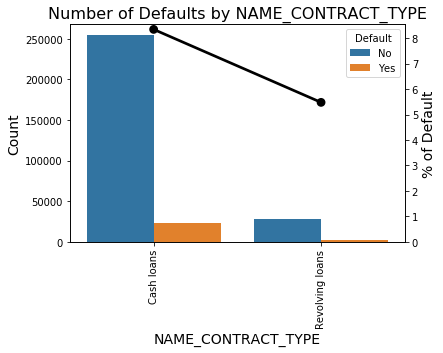

TARGET CODE_GENDER  Non Default    Default
0                F    93.000672   6.999328
1                M    89.858080  10.141920
2              XNA   100.000000   0.000000


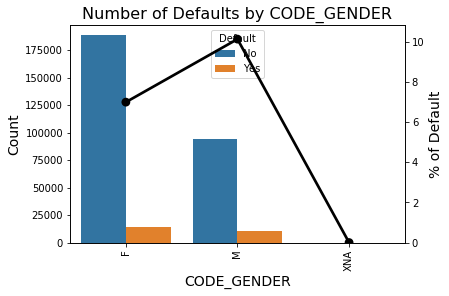

TARGET FLAG_OWN_CAR  Non Default   Default
0                 N    91.499773  8.500227
1                 Y    92.756270  7.243730


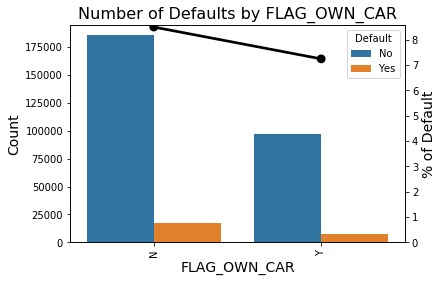

TARGET FLAG_OWN_REALTY  Non Default   Default
0                    N    91.675071  8.324929
1                    Y    92.038423  7.961577


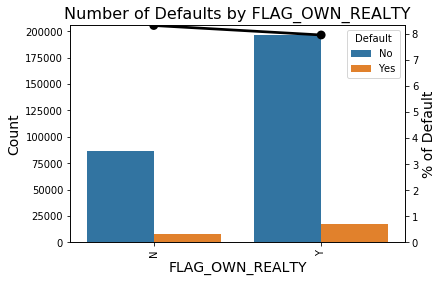

In [10]:
def vis_cat(df, varlist):
    tmp = pd.crosstab(df[varlist], df['TARGET'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'Non Default', 1:'Default'}, inplace=True)
    print(tmp)

    g = sns.countplot(x=varlist, data=df, hue='TARGET', order=list(tmp[varlist].sort_values().unique()))
    g.set_title(f"Number of Defaults by {varlist}", fontsize=16)
    g.set_xlabel(f"{varlist}", fontsize=14)
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set_ylabel('Count', fontsize=14)
    plt.legend(title='Default', loc='best', labels=['No', 'Yes'])
    gt = g.twinx()
    gt = sns.pointplot(x=varlist, y='Default', data=tmp, 
                       order=list(tmp[varlist].sort_values().unique()), color='black', legend=False)
    gt.set_ylabel("% of Default", fontsize=14)
    gt.set_ylim(0,)
    
    plt.show()
    
    
varlist_1 = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY']
for i in varlist_1:
    vis_cat(data_all, i)

#### Print the default status by documentation status for 2 - 21 documents. See if the absence of any documentation (2-21) could lead to more defaults. Looks like for most documentations, having them filled has a lower default rate than not having them filled (~8% population level default rate).

TARGET  FLAG_DOCUMENT_2  Non Default    Default
0                     0    91.928078   8.071922
1                     1    69.230769  30.769231


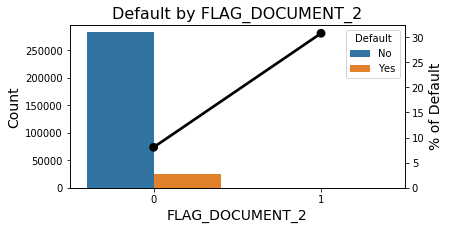

TARGET  FLAG_DOCUMENT_3  Non Default   Default
0                     0    93.817497  6.182503
1                     1    91.155079  8.844921


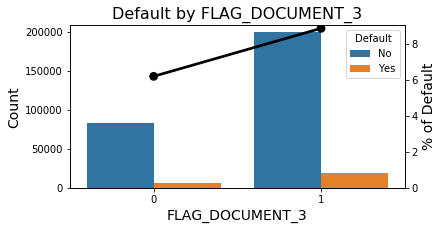

TARGET  FLAG_DOCUMENT_4  Non Default   Default
0                     0    91.926462  8.073538
1                     1   100.000000  0.000000


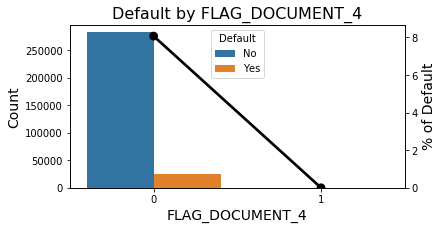

TARGET  FLAG_DOCUMENT_5  Non Default   Default
0                     0    91.926052  8.073948
1                     1    91.996558  8.003442


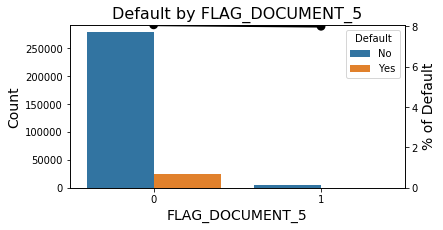

TARGET  FLAG_DOCUMENT_6  Non Default   Default
0                     0    91.685001  8.314999
1                     1    94.434596  5.565404


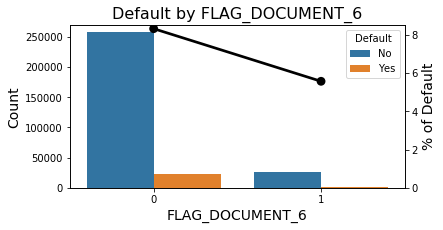

TARGET  FLAG_DOCUMENT_7  Non Default   Default
0                     0    91.926545  8.073455
1                     1    94.915254  5.084746


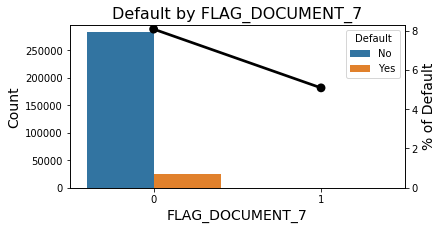

TARGET  FLAG_DOCUMENT_8  Non Default   Default
0                     0    91.861926  8.138074
1                     1    92.663043  7.336957


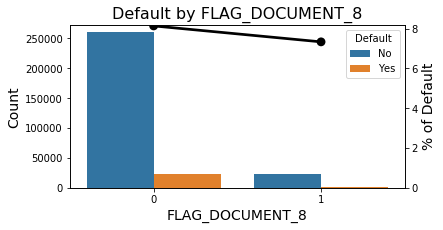

TARGET  FLAG_DOCUMENT_9  Non Default   Default
0                     0    91.919703  8.080297
1                     1    93.823038  6.176962


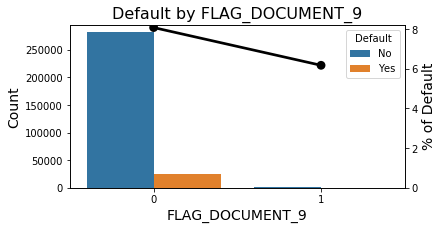

TARGET  FLAG_DOCUMENT_10  Non Default   Default
0                      0    91.926934  8.073066
1                      1   100.000000  0.000000


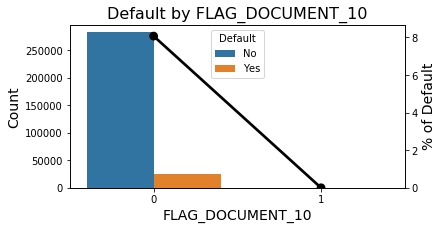

TARGET  FLAG_DOCUMENT_11  Non Default   Default
0                      0    91.919898  8.080102
1                      1    93.765586  6.234414


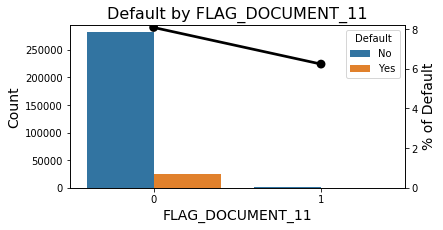

TARGET  FLAG_DOCUMENT_12  Non Default   Default
0                      0    91.927066  8.072934
1                      1   100.000000  0.000000


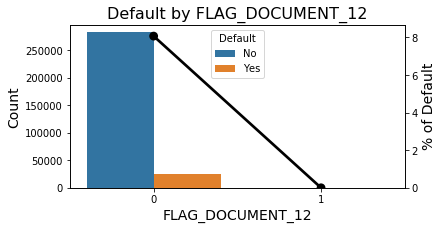

TARGET  FLAG_DOCUMENT_13  Non Default   Default
0                      0    91.908350  8.091650
1                      1    97.232472  2.767528


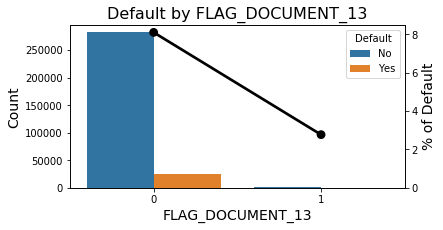

TARGET  FLAG_DOCUMENT_14  Non Default   Default
0                      0    91.913127  8.086873
1                      1    96.677741  3.322259


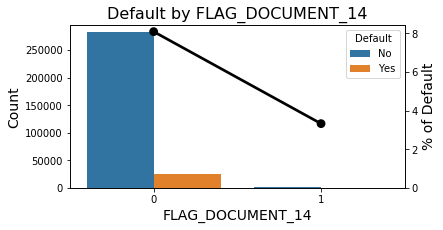

TARGET  FLAG_DOCUMENT_15  Non Default   Default
0                      0    91.920922  8.079078
1                      1    97.043011  2.956989


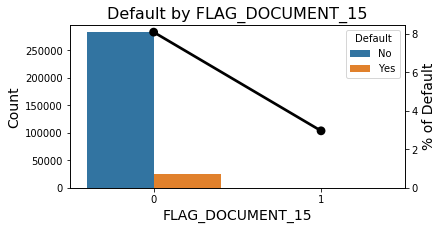

TARGET  FLAG_DOCUMENT_16  Non Default   Default
0                      0    91.895434  8.104566
1                      1    95.086800  4.913200


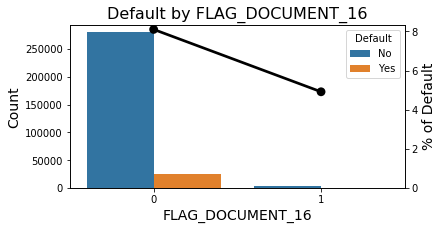

TARGET  FLAG_DOCUMENT_17  Non Default   Default
0                      0    91.925615  8.074385
1                      1    97.560976  2.439024


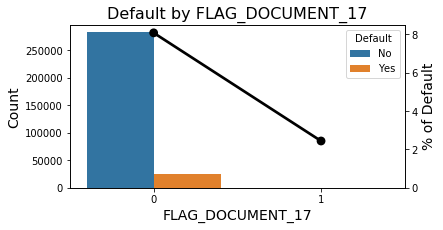

TARGET  FLAG_DOCUMENT_18  Non Default   Default
0                      0    91.907505  8.092495
1                      1    94.320000  5.680000


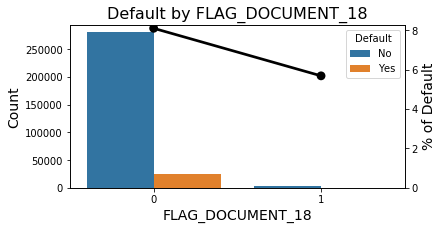

TARGET  FLAG_DOCUMENT_19  Non Default   Default
0                      0    91.926216  8.073784
1                      1    93.442623  6.557377


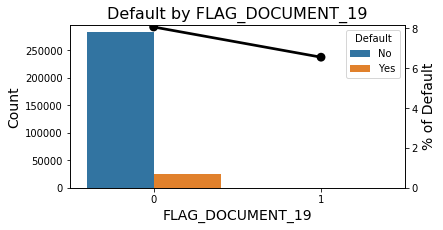

TARGET  FLAG_DOCUMENT_20  Non Default   Default
0                      0    91.927250  8.072750
1                      1    91.666667  8.333333


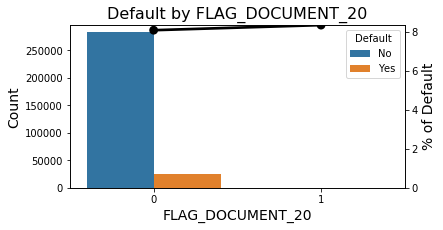

TARGET  FLAG_DOCUMENT_21  Non Default    Default
0                      0    91.928967   8.071033
1                      1    86.407767  13.592233


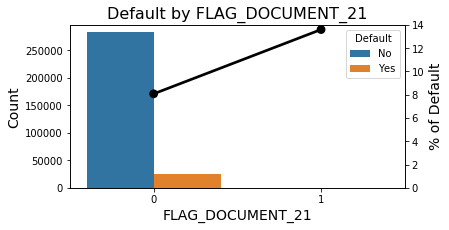

In [11]:
def plot_document(df, i):
    columname = 'FLAG_DOCUMENT_' + str(i+1)
    tmp = pd.crosstab(df[columname], df['TARGET'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'Non Default', 1:'Default'}, inplace=True)
    print(tmp)

    g = sns.countplot(x=columname, data=df, hue='TARGET', order=list(tmp[columname].values))
    g.set_title(f'Default by {columname}', fontsize=16)
    g.set_xlabel(f'{columname}', fontsize=14)
    g.set_ylabel('Count', fontsize=14)
    plt.legend(title='Default', loc='best', labels=['No', 'Yes'])
    gt = g.twinx()
    gt = sns.pointplot(x=columname, y='Default', data=tmp, order=list(tmp[columname].values), color='black', legend=False)
    gt.set_ylabel("% of Default", fontsize=14)
    gt.set_ylim(0,)
    
    plt.show()
    
    
for i in range(1,21):
    plt.figure(figsize=(6,3))
    plot_document(data_all, i)

#### NAME, FLAG and some other categorical variables. Group some variables with high cardinality into fewer categories.

TARGET  NAME_TYPE_SUITE  Non Default   Default
0              Children    92.623202  7.376798
1                Family    92.505417  7.494583
2       Group of people    91.512915  8.487085
3               Other_A    91.224018  8.775982
4               Other_B    90.169492  9.830508
5       Spouse, partner    92.128408  7.871592
6         Unaccompanied    91.816953  8.183047


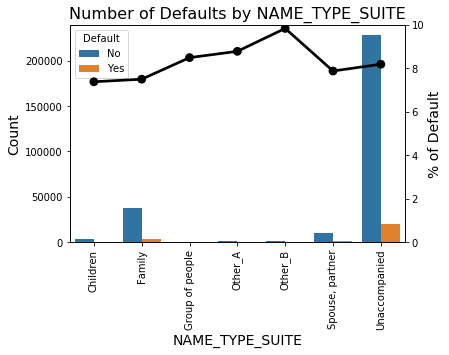

TARGET      NAME_INCOME_TYPE  Non Default    Default
0                Businessman   100.000000   0.000000
1       Commercial associate    92.515743   7.484257
2            Maternity leave    60.000000  40.000000
3                  Pensioner    94.613634   5.386366
4              State servant    94.245035   5.754965
5                    Student   100.000000   0.000000
6                 Unemployed    63.636364  36.363636
7                    Working    90.411528   9.588472


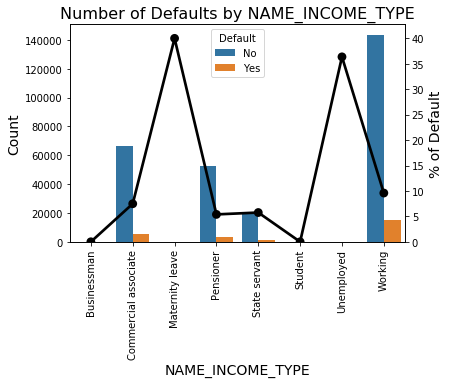

TARGET            NAME_EDUCATION_TYPE  Non Default    Default
0                     Academic degree    98.170732   1.829268
1                    Higher education    94.644885   5.355115
2                   Incomplete higher    91.515034   8.484966
3                     Lower secondary    89.072327  10.927673
4       Secondary / secondary special    91.060071   8.939929


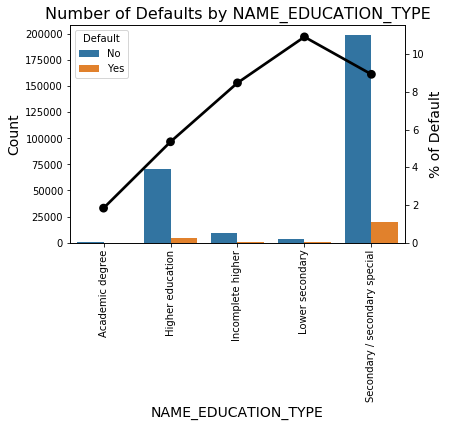

TARGET    NAME_FAMILY_STATUS  Non Default   Default
0             Civil marriage    90.055416  9.944584
1                    Married    92.440132  7.559868
2                  Separated    91.805766  8.194234
3       Single / not married    90.192325  9.807675
4                    Unknown   100.000000  0.000000
5                      Widow    94.175783  5.824217


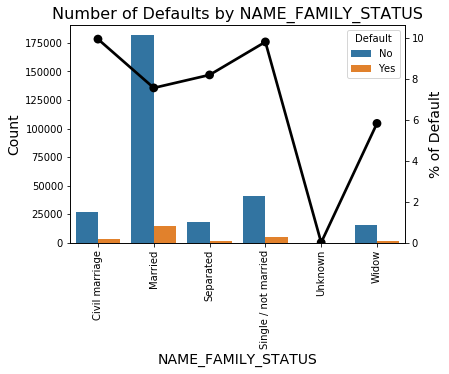

TARGET    NAME_HOUSING_TYPE  Non Default    Default
0           Co-op apartment    92.067736   7.932264
1         House / apartment    92.204289   7.795711
2       Municipal apartment    91.460252   8.539748
3          Office apartment    93.427589   6.572411
4          Rented apartment    87.686949  12.313051
5              With parents    88.301887  11.698113


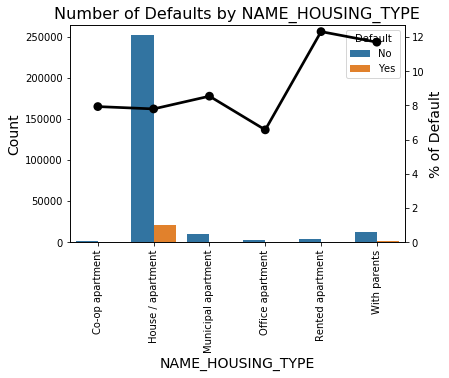

TARGET  FLAG_MOBIL  Non Default   Default
0                0   100.000000  0.000000
1                1    91.927092  8.072908


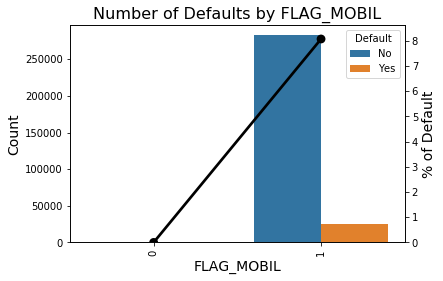

TARGET  FLAG_EMP_PHONE  Non Default   Default
0                    0    94.599718  5.400282
1                    1    91.340010  8.659990


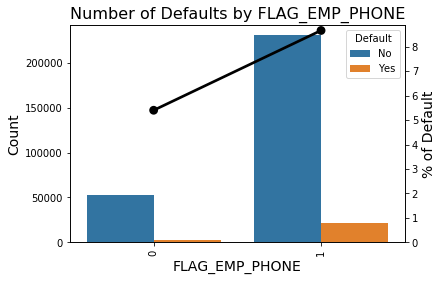

TARGET  FLAG_WORK_PHONE  Non Default   Default
0                     0    92.314878  7.685122
1                     1    90.369935  9.630065


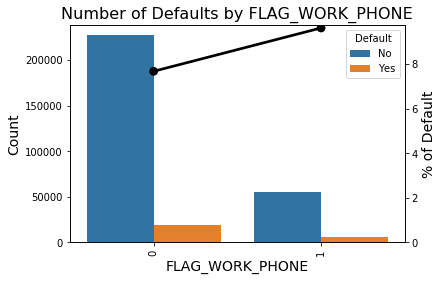

TARGET  FLAG_CONT_MOBILE  Non Default   Default
0                      0    92.160279  7.839721
1                      1    91.926682  8.073318


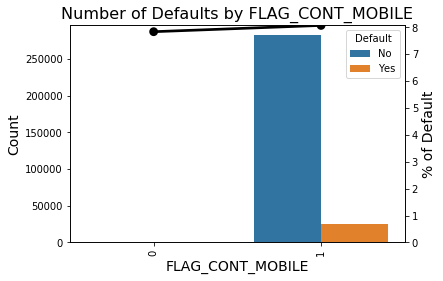

TARGET  FLAG_PHONE  Non Default   Default
0                0    91.521621  8.478379
1                1    92.964330  7.035670


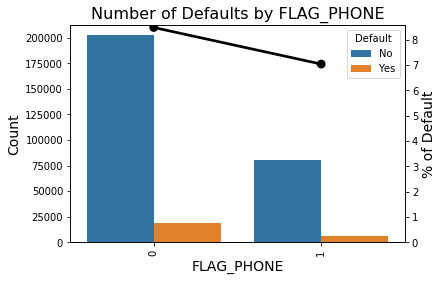

TARGET  FLAG_EMAIL  Non Default   Default
0                0    91.915372  8.084628
1                1    92.122463  7.877537


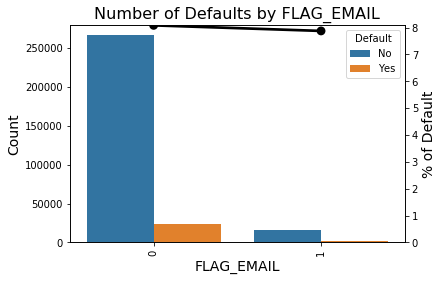

TARGET  CNT_CHILDREN  Non Default     Default
0                  0    92.288191    7.711809
1                  1    91.076425    8.923575
2                  2    91.278179    8.721821
3                  3    90.368577    9.631423
4                  4    87.179487   12.820513
5                  5    91.666667    8.333333
6                  6    71.428571   28.571429
7                  7   100.000000    0.000000
8                  8   100.000000    0.000000
9                  9     0.000000  100.000000
10                10   100.000000    0.000000
11                11     0.000000  100.000000
12                12   100.000000    0.000000
13                14   100.000000    0.000000
14                19   100.000000    0.000000


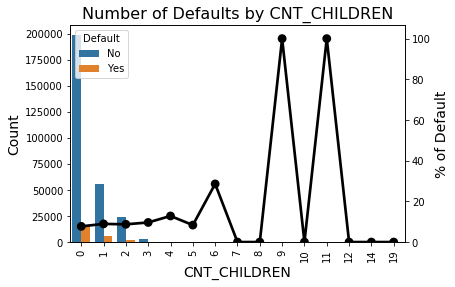

TARGET        OCCUPATION_TYPE  Non Default    Default
0                 Accountants    95.169673   4.830327
1              Cleaning staff    90.393295   9.606705
2               Cooking staff    89.556004  10.443996
3                  Core staff    93.696046   6.303954
4                     Drivers    88.673870  11.326130
5                    HR staff    93.605684   6.394316
6       High skill tech staff    93.840070   6.159930
7                    IT staff    93.536122   6.463878
8                    Laborers    89.421230  10.578770
9          Low-skill Laborers    82.847587  17.152413
10                   Managers    93.785972   6.214028
11             Medicine staff    93.299754   6.700246
12      Private service staff    93.401207   6.598793
13              Realty agents    92.143808   7.856192
14                Sales staff    90.368201   9.631799
15                Secretaries    92.950192   7.049808
16             Security staff    89.257551  10.742449
17       Waiters/barmen staf

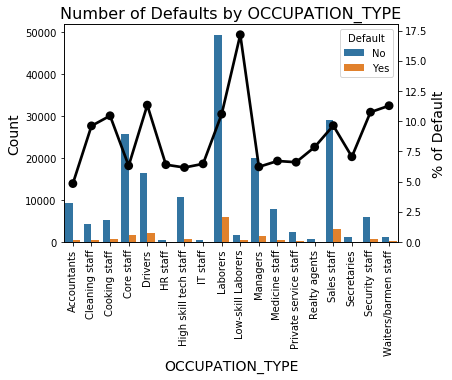

TARGET       ORGANIZATION_TYPE  Non Default    Default
0                  Advertising    91.841492   8.158508
1                  Agriculture    89.527302  10.472698
2                         Bank    94.814519   5.185481
3       Business Entity Type 1    91.861631   8.138369
4       Business Entity Type 2    91.471619   8.528381
5       Business Entity Type 3    90.700377   9.299623
6                     Cleaning    88.846154  11.153846
7                 Construction    88.320190  11.679810
8                      Culture    94.459103   5.540897
9                  Electricity    93.368421   6.631579
10                   Emergency    92.857143   7.142857
11                  Government    93.021915   6.978085
12                       Hotel    93.581781   6.418219
13                     Housing    92.055443   7.944557
14            Industry: type 1    88.931665  11.068335
15           Industry: type 10    93.577982   6.422018
16           Industry: type 11    91.346154   8.653846
17        

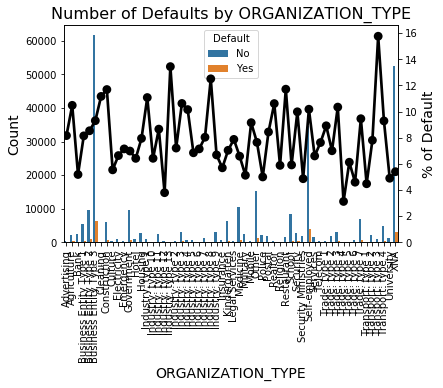

TARGET  CNT_FAM_MEMBERS  Non Default     Default
0                   1.0    91.635592    8.364408
1                   2.0    92.416502    7.583498
2                   3.0    91.239710    8.760290
3                   4.0    91.351176    8.648824
4                   5.0    90.598045    9.401955
5                   6.0    86.519608   13.480392
6                   7.0    92.592593    7.407407
7                   8.0    70.000000   30.000000
8                   9.0   100.000000    0.000000
9                  10.0    66.666667   33.333333
10                 11.0     0.000000  100.000000
11                 12.0   100.000000    0.000000
12                 13.0     0.000000  100.000000
13                 14.0   100.000000    0.000000
14                 15.0   100.000000    0.000000
15                 16.0   100.000000    0.000000
16                 20.0   100.000000    0.000000


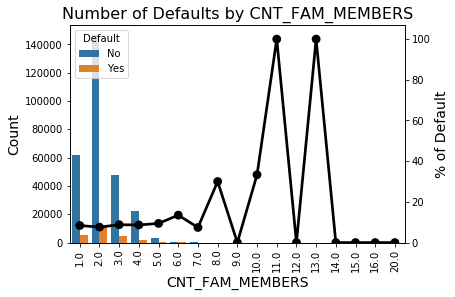

TARGET WEEKDAY_APPR_PROCESS_START  Non Default   Default
0                          FRIDAY    91.853073  8.146927
1                          MONDAY    92.242773  7.757227
2                        SATURDAY    92.112726  7.887274
3                          SUNDAY    92.070947  7.929053
4                        THURSDAY    91.899745  8.100255
5                         TUESDAY    91.649506  8.350494
6                       WEDNESDAY    91.839643  8.160357


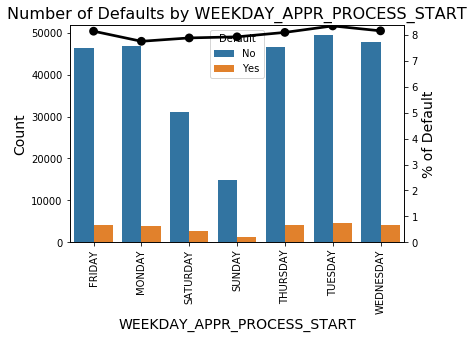

TARGET  HOUR_APPR_PROCESS_START  Non Default    Default
0                             0    85.000000  15.000000
1                             1    91.860465   8.139535
2                             2    90.163934   9.836066
3                             3    91.300813   8.699187
4                             4    91.722488   8.277512
5                             5    89.417262  10.582738
6                             6    88.959261  11.040739
7                             7    89.957288  10.042712
8                             8    90.923514   9.076486
9                             9    91.794479   8.205521
10                           10    91.978156   8.021844
11                           11    91.925649   8.074351
12                           12    91.741886   8.258114
13                           13    91.973255   8.026745
14                           14    92.092334   7.907666
15                           15    92.407102   7.592898
16                           16    92.538631   7

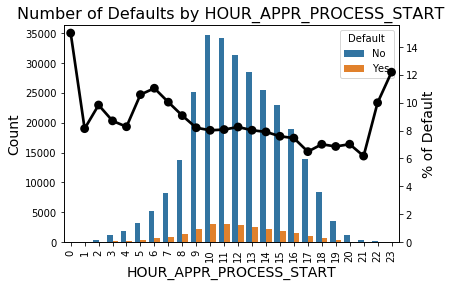

TARGET  REGION_RATING_CLIENT  Non Default    Default
0                          1    95.179675   4.820325
1                          2    92.110898   7.889102
2                          3    88.897165  11.102835


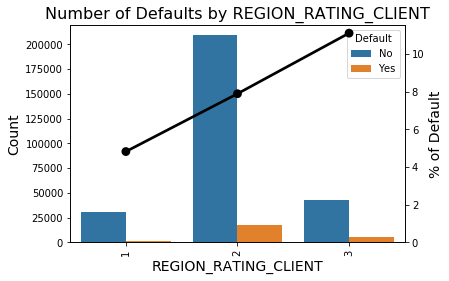

TARGET  REGION_RATING_CLIENT_W_CITY  Non Default    Default
0                                 1    95.159072   4.840928
1                                 2    92.082237   7.917763
2                                 3    88.597811  11.402189


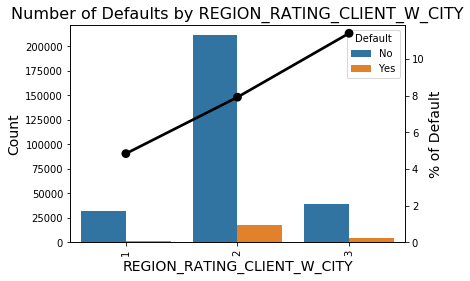

TARGET  REG_REGION_NOT_LIVE_REGION  Non Default   Default
0                                0    91.945954  8.054046
1                                1    90.702169  9.297831


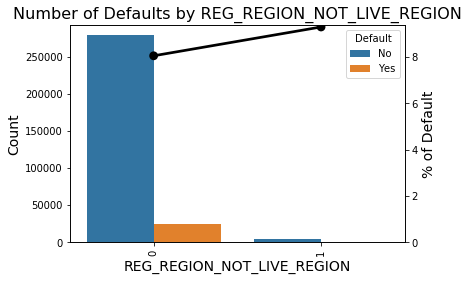

TARGET  REG_REGION_NOT_WORK_REGION  Non Default   Default
0                                0    91.970853  8.029147
1                                1    91.109403  8.890597


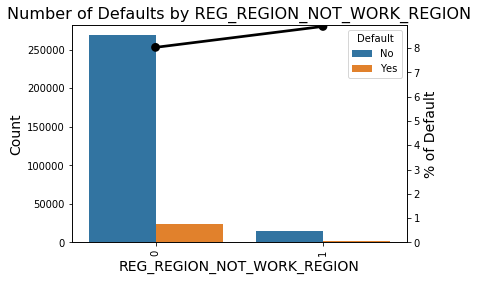

TARGET  REG_CITY_NOT_WORK_CITY  Non Default    Default
0                            0    92.687328   7.312672
1                            1    89.388573  10.611427


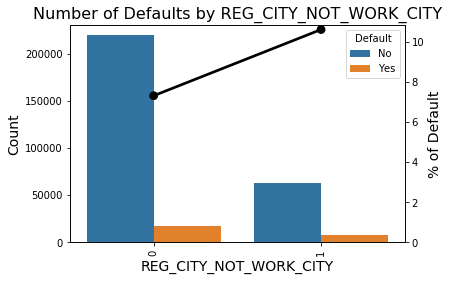

TARGET  REG_CITY_NOT_LIVE_CITY  Non Default    Default
0                            0    92.279308   7.720692
1                            1    87.774034  12.225966


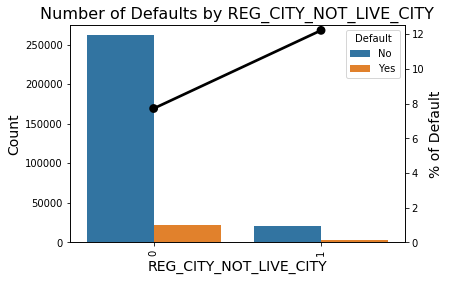

TARGET  LIVE_REGION_NOT_WORK_REGION  Non Default   Default
0                                 0    91.942930  8.057070
1                                 1    91.554027  8.445973


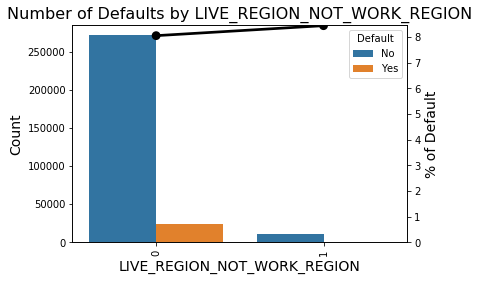

TARGET  LIVE_CITY_NOT_WORK_CITY  Non Default   Default
0                             0    92.341535  7.658465
1                             1    90.033505  9.966495


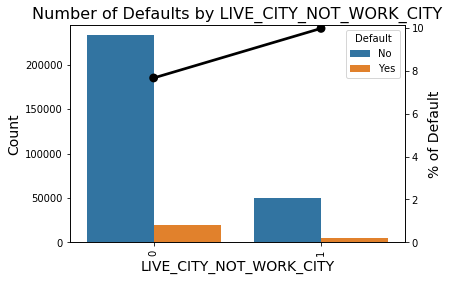

TARGET EMERGENCYSTATE_MODE  Non Default   Default
0                       No    93.035100  6.964900
1                      Yes    90.420962  9.579038


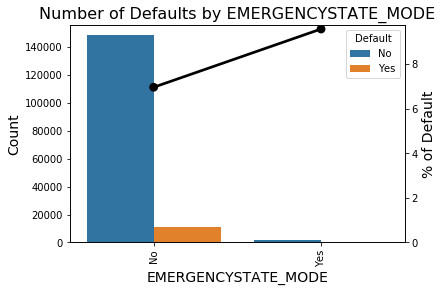

TARGET    HOUSETYPE_MODE  Non Default    Default
0         block of flats    93.056617   6.943383
1       specific housing    89.859907  10.140093
2         terraced house    91.501650   8.498350


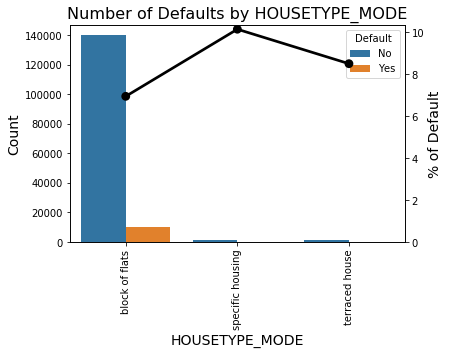

TARGET WALLSMATERIAL_MODE  Non Default   Default
0                   Block    92.975251  7.024749
1                   Mixed    92.465157  7.534843
2              Monolithic    95.278246  4.721754
3                  Others    91.692308  8.307692
4                   Panel    93.652332  6.347668
5            Stone, brick    92.594307  7.405693
6                  Wooden    90.302126  9.697874


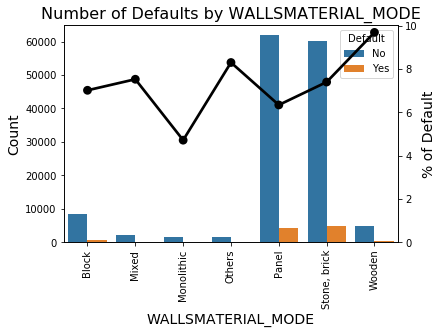

In [12]:
types = ['NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
        'FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL',
        'CNT_CHILDREN','OCCUPATION_TYPE','ORGANIZATION_TYPE','CNT_FAM_MEMBERS',
         'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
        'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
        'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','REG_CITY_NOT_WORK_CITY','REG_CITY_NOT_LIVE_CITY',
        'LIVE_REGION_NOT_WORK_REGION','LIVE_CITY_NOT_WORK_CITY',
        'EMERGENCYSTATE_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE']
for i in types:
    vis_cat(data_all, i)

#### Notice that there are blank and nan values need to be treated in some of the variables

posx and posy should be finite values
posx and posy should be finite values


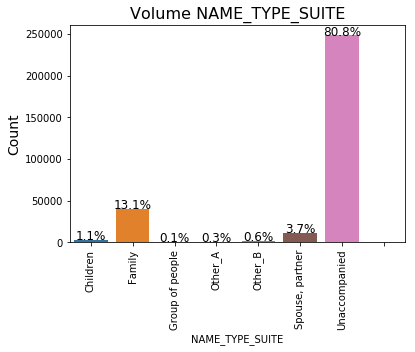

Volume in each category of NAME_TYPE_SUITE Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64


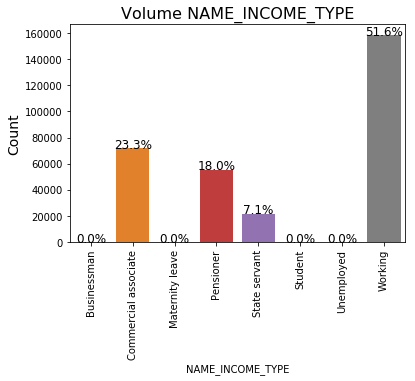

Volume in each category of NAME_INCOME_TYPE Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64


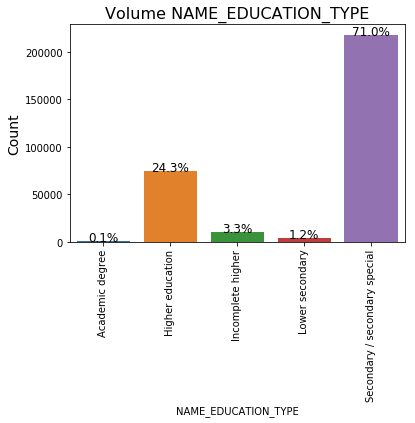

Volume in each category of NAME_EDUCATION_TYPE Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64


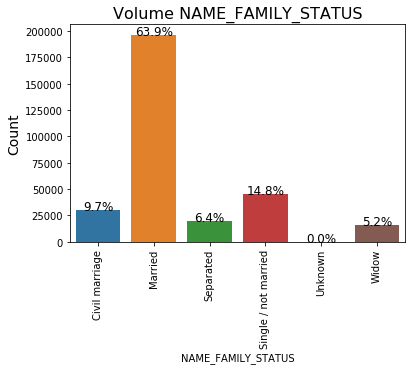

Volume in each category of NAME_FAMILY_STATUS Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64


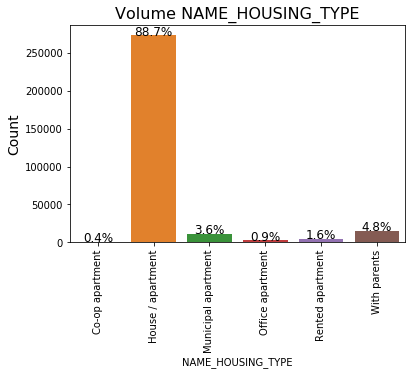

Volume in each category of NAME_HOUSING_TYPE House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64


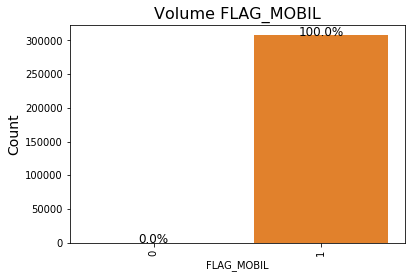

Volume in each category of FLAG_MOBIL 1    307510
0         1
Name: FLAG_MOBIL, dtype: int64


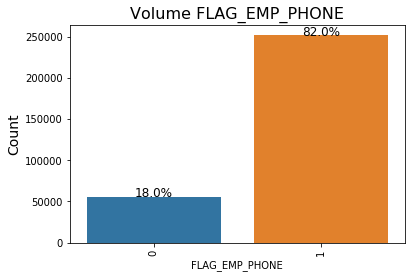

Volume in each category of FLAG_EMP_PHONE 1    252125
0     55386
Name: FLAG_EMP_PHONE, dtype: int64


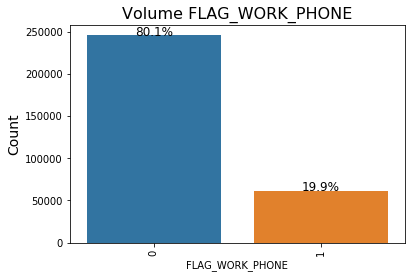

Volume in each category of FLAG_WORK_PHONE 0    246203
1     61308
Name: FLAG_WORK_PHONE, dtype: int64


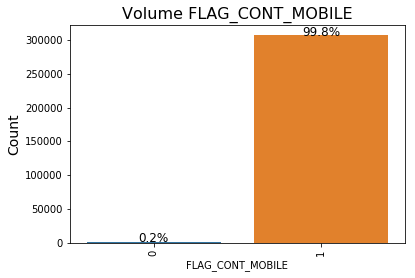

Volume in each category of FLAG_CONT_MOBILE 1    306937
0       574
Name: FLAG_CONT_MOBILE, dtype: int64


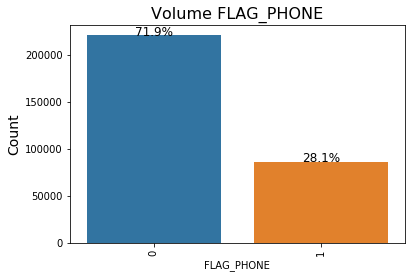

Volume in each category of FLAG_PHONE 0    221080
1     86431
Name: FLAG_PHONE, dtype: int64


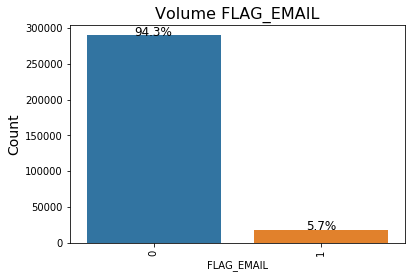

Volume in each category of FLAG_EMAIL 0    290069
1     17442
Name: FLAG_EMAIL, dtype: int64


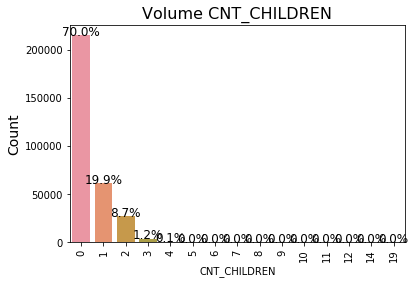

Volume in each category of CNT_CHILDREN 0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
19         2
12         2
10         2
9          2
8          2
11         1
Name: CNT_CHILDREN, dtype: int64


posx and posy should be finite values
posx and posy should be finite values


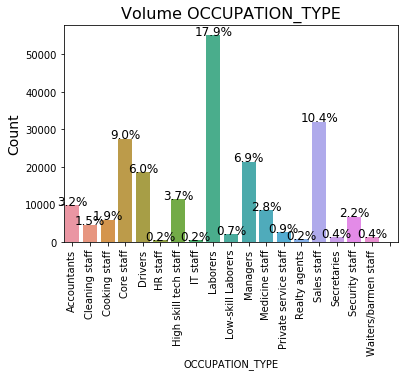

Volume in each category of OCCUPATION_TYPE Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64


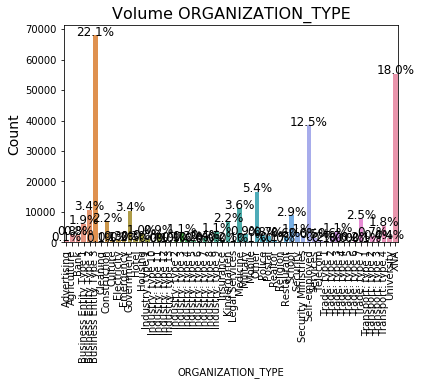

posx and posy should be finite values


Volume in each category of ORGANIZATION_TYPE Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 

posx and posy should be finite values


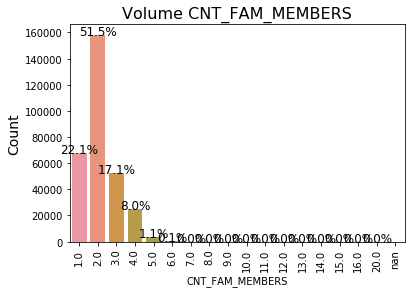

Volume in each category of CNT_FAM_MEMBERS 2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
16.0         2
12.0         2
20.0         2
11.0         1
13.0         1
15.0         1
Name: CNT_FAM_MEMBERS, dtype: int64


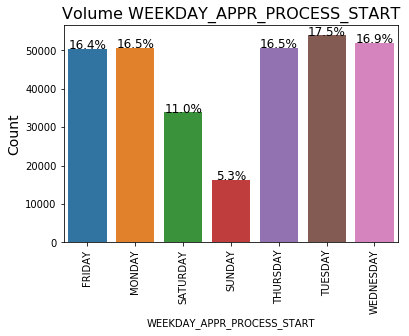

Volume in each category of WEEKDAY_APPR_PROCESS_START TUESDAY      53901
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50591
FRIDAY       50338
SATURDAY     33852
SUNDAY       16181
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64


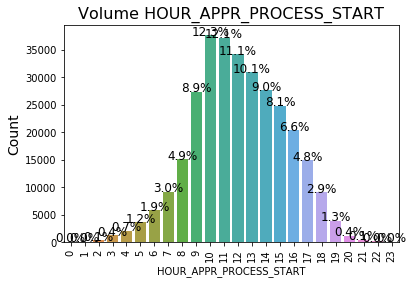

Volume in each category of HOUR_APPR_PROCESS_START 10    37722
11    37229
12    34233
13    30959
14    27682
9     27384
15    24839
16    20385
8     15127
17    14900
7      9131
18     9049
6      5842
19     3848
5      3638
4      2090
3      1230
20     1196
21      405
2       305
22      150
1        86
23       41
0        40
Name: HOUR_APPR_PROCESS_START, dtype: int64


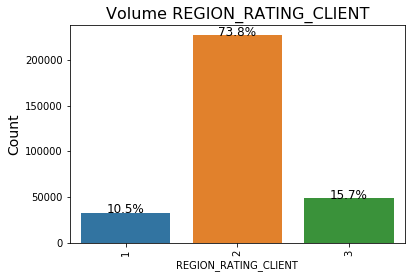

Volume in each category of REGION_RATING_CLIENT 2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64


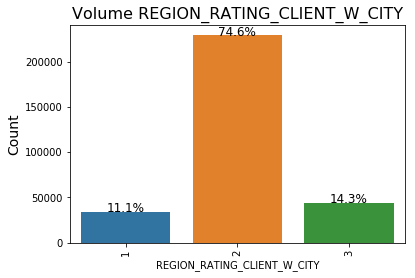

Volume in each category of REGION_RATING_CLIENT_W_CITY 2    229484
3     43860
1     34167
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64


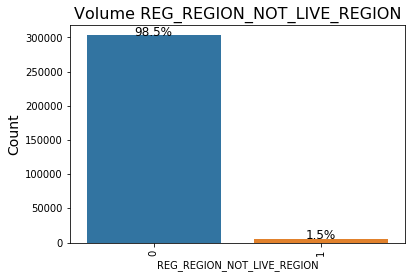

Volume in each category of REG_REGION_NOT_LIVE_REGION 0    302854
1      4657
Name: REG_REGION_NOT_LIVE_REGION, dtype: int64


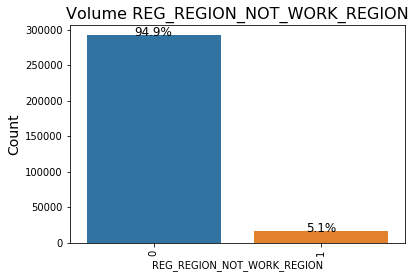

Volume in each category of REG_REGION_NOT_WORK_REGION 0    291899
1     15612
Name: REG_REGION_NOT_WORK_REGION, dtype: int64


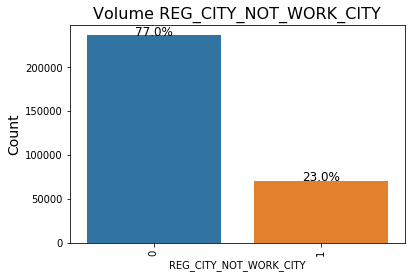

Volume in each category of REG_CITY_NOT_WORK_CITY 0    236644
1     70867
Name: REG_CITY_NOT_WORK_CITY, dtype: int64


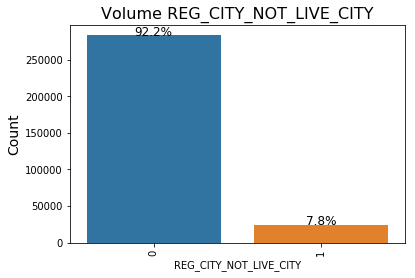

Volume in each category of REG_CITY_NOT_LIVE_CITY 0    283472
1     24039
Name: REG_CITY_NOT_LIVE_CITY, dtype: int64


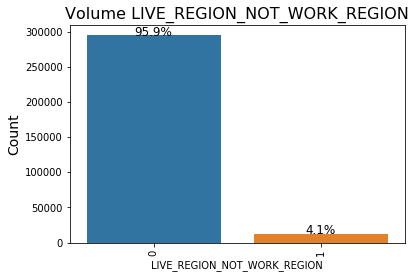

Volume in each category of LIVE_REGION_NOT_WORK_REGION 0    295008
1     12503
Name: LIVE_REGION_NOT_WORK_REGION, dtype: int64


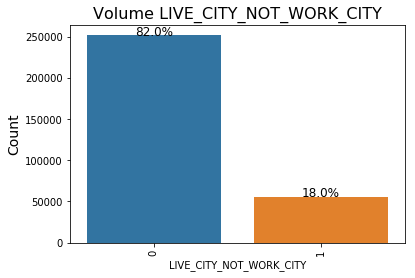

Volume in each category of LIVE_CITY_NOT_WORK_CITY 0    252296
1     55215
Name: LIVE_CITY_NOT_WORK_CITY, dtype: int64


posx and posy should be finite values
posx and posy should be finite values


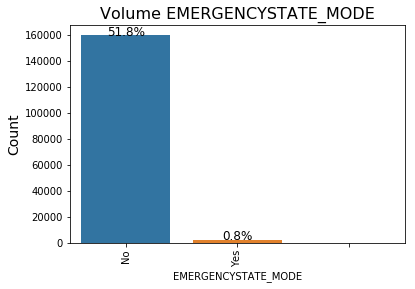

Volume in each category of EMERGENCYSTATE_MODE No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64


posx and posy should be finite values
posx and posy should be finite values


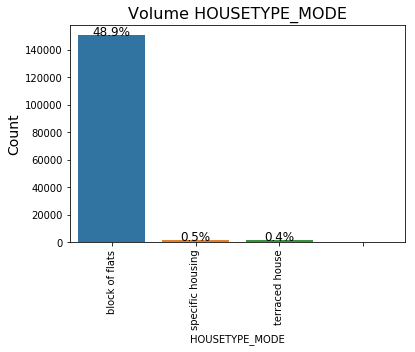

Volume in each category of HOUSETYPE_MODE block of flats      150503
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64


posx and posy should be finite values
posx and posy should be finite values


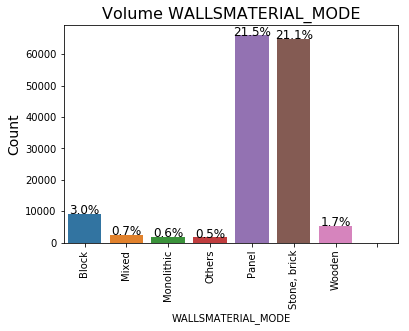

Volume in each category of WALLSMATERIAL_MODE Panel           66040
Stone, brick    64815
Block            9253
Wooden           5362
Mixed            2296
Monolithic       1779
Others           1625
Name: WALLSMATERIAL_MODE, dtype: int64


In [13]:
for i in types:
    g = sns.countplot(x=i, data=data_all, order=list(data_all[i].sort_values().unique()))
    g.set_title(f"Volume {i}", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set_ylabel('Count', fontsize=14)
    total = len(data_all)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(height/total*100),
                ha="center", fontsize=12) 
    plt.show()
    print(f'Volume in each category of {i}', data_all[i].value_counts())

### Combine some categories of some variables if the cardinality is high.
1. NAME_TYPE_SUITE: treat nan using a new category 'UKN', then do one hot encoder.
2. NAME_INCOME_TYPE: one hot encoder
3. NAME_EDUCATION_TYPE: one hot encoder
4. NAME_FAMILY_STATUS: one hot encoder
5. NAME_HOUSING_TYPE: one hot encoder
6. OCCUPATION_TYPE: any groups with < 10000 counts are grouped together, then do one hot encoder
7. ORGANIZATION_TYPE: any groups with < 30000 counts are grouped together, then do one hot encoder
8. WALLSMATERIAL_MODE: treat nan using a new category 'UKN', then do one hot encoder

In [14]:
# define nan as a new category 'UKN' to avoid one-hot coding errors
data_all['NAME_TYPE_SUITE'][data_all['NAME_TYPE_SUITE'].isna()] = 'UKN'
data_all['WALLSMATERIAL_MODE'][data_all['WALLSMATERIAL_MODE'].isna()] = 'UKN'
data_all['OCCUPATION_TYPE'][data_all['OCCUPATION_TYPE'].isna()] = 'UKN'
data_all['HOUSETYPE_MODE'][data_all['HOUSETYPE_MODE'].isna()] = 'UKN'
data_all['EMERGENCYSTATE_MODE'][data_all['EMERGENCYSTATE_MODE'].isna()] = 'UKN'

# define all the frequency < 10000 categories as 'Others'
data_all.loc[data_all['OCCUPATION_TYPE'].isin
        (data_all['OCCUPATION_TYPE'].value_counts()[data_all['OCCUPATION_TYPE'].value_counts() <= 10000].index),
             'OCCUPATION_TYPE']='Others'

# define all the frequency < 30000 categories as 'Others'
data_all.loc[data_all['ORGANIZATION_TYPE'].isin
        (data_all['ORGANIZATION_TYPE'].value_counts()[data_all['ORGANIZATION_TYPE'].value_counts() <= 30000].index),
             'ORGANIZATION_TYPE']='Others'

# create one hot coding for the categorical variables
# note that in previous application dataset there are columns aggregated to exactly the same variable name, need to 
# distinguish using sufix CURR to indicate the one hot encoded variable comes from current application dataset  
for co in data_all.columns:
    if data_all[co].dtypes == 'O':
        unique_value = data_all[co].unique()
        for val in unique_value:
            data_all.loc[data_all[co]==val,co+val+'CURR'] = 1
            data_all.loc[data_all[co]!=val,co+val+'CURR'] = 0

# drop the original categorical variables to remove redundancy
data_all.drop(['NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
               'OCCUPATION_TYPE','ORGANIZATION_TYPE','WALLSMATERIAL_MODE','HOUSETYPE_MODE','EMERGENCYSTATE_MODE',
               'NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','WEEKDAY_APPR_PROCESS_START'], 
              axis=1, inplace=True)            

/Users/lisalb168/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lisalb168/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lisalb168/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys

## 5. Check this intermediate cleaned up table and save it in SQLite database

In [15]:
details = table_details(data_all)
# no more object types in the dataset
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(details)

Dataset Shape: (307511, 354)


Name   dtypes  Missing  \
0                                               TARGET    int64        0   
1                                         CNT_CHILDREN    int64        0   
2                                     AMT_INCOME_TOTAL  float64        0   
3                                           AMT_CREDIT  float64        0   
4                                          AMT_ANNUITY  float64       12   
5                                      AMT_GOODS_PRICE  float64      278   
6                           REGION_POPULATION_RELATIVE  float64        0   
7                                           DAYS_BIRTH    int64        0   
8                                        DAYS_EMPLOYED    int64        0   
9                                    DAYS_REGISTRATION  float64        0   
10                                     DAYS_ID_PUBLISH    int64        0   
11                                          FLAG_MOBIL    int64        0   
12                                      FLAG_EMP_PHONE    int64        0   
13                                     FLAG_WORK_PHONE    int64        0   
14                                    FLAG_CONT_MOBILE    int64        0   
15                                          FLAG_PHONE    int64        0   
16                                          FLAG_EMAIL    int64        0   
17                                     CNT_FAM_MEMBERS  float64        2   
18                                REGION_RATING_CLIENT    int64        0   
19                         REGION_RATING_CLIENT_W_CITY    int64        0   
20                             HOUR_APPR_PROCESS_START    int64        0   
21                          REG_REGION_NOT_LIVE_REGION    int64        0   
22                          REG_REGION_NOT_WORK_REGION    int64        0   
23                         LIVE_REGION_NOT_WORK_REGION    int64        0   
24                              REG_CITY_NOT_LIVE_CITY    int64        0   
25                              REG_CITY_NOT_WORK_CITY    int64        0   
26                             LIVE_CITY_NOT_WORK_CITY    int64        0   
27                                        EXT_SOURCE_1  float64   173378   
28                                        EXT_SOURCE_2  float64      660   
29                                        EXT_SOURCE_3  float64    60965   
30                                      APARTMENTS_AVG  float64   156061   
31                                    BASEMENTAREA_AVG  float64   179943   
32                         YEARS_BEGINEXPLUATATION_AVG  float64   150007   
33                                       ELEVATORS_AVG  float64   163891   
34                                       ENTRANCES_AVG  float64   154828   
35                                       FLOORSMAX_AVG  float64   153020   
36                                        LANDAREA_AVG  float64   182590   
37                                      LIVINGAREA_AVG  float64   154350   
38                                   NONLIVINGAREA_AVG  float64   169682   
39                                     APARTMENTS_MODE  float64   156061   
40                                   BASEMENTAREA_MODE  float64   179943   
41                        YEARS_BEGINEXPLUATATION_MODE  float64   150007   
42                                      ELEVATORS_MODE  float64   163891   
43                                      ENTRANCES_MODE  float64   154828   
44                                      FLOORSMAX_MODE  float64   153020   
45                                       LANDAREA_MODE  float64   182590   
46                                     LIVINGAREA_MODE  float64   154350   
47                                  NONLIVINGAREA_MODE  float64   169682   
48                                     APARTMENTS_MEDI  float64   156061   
49                                   BASEMENTAREA_MEDI  float64   179943   
50                        YEARS_BEGINEXPLUATATION_MEDI  float64   150007   
51                                      ELEVATORS_MEDI  float64   163891   
52                    

In [16]:
# save the cleaned data_all to sqlite database
# open connection to sqlite database 
con = sqlite3.connect(r"pythonsqlite.db")
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS data_all_2')
data_all.to_sql(name='data_all_2', index=False, con=con)
con.commit()
con.close()

/Users/lisalb168/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2531: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)


## 6. EDA for numeric variables

In [17]:
# open connection to sqlite database 
import sqlite3
from sqlite3 import Error
# open connection to sqlite database 
con = sqlite3.connect(r"pythonsqlite.db")
cur = con.cursor()
sql_sm = '''SELECT A.* FROM data_all_2 AS A'''
data_all_2 = pd.read_sql(sql_sm, coerce_float=True, con=con)
# close the connection
con.close()

#### The following variables are skewed to the right, create visualizations by zooming in the left part.

In [18]:
def snskdeplot(col, thresh):
    plt.figure(figsize = (15, 5))
    
    plt.subplot(121)
    # KDE plot of loans that were on time
    sns.kdeplot(data_all_2.loc[data_all_2['TARGET'] == 0, col], label = 'target == 0')

    # KDE plot of loans which were not on time / Default
    sns.kdeplot(data_all_2.loc[data_all_2['TARGET'] == 1, col], label = 'target == 1')

    # Labeling of plot
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f"Distribution of {col}")
    
    plt.subplot(122)
    
    ttt = data_all_2[['TARGET', col]][data_all_2[col] < thresh]
    # KDE plot of loans that were on time
    sns.kdeplot(ttt.loc[ttt['TARGET'] == 0, col], label = 'target == 0')

    # KDE plot of loans which were not on time / Default
    sns.kdeplot(ttt.loc[ttt['TARGET'] == 1, col], label = 'target == 1')

    # Labeling of plot
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f"Distribution of {col}")

/Users/lisalb168/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/lisalb168/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


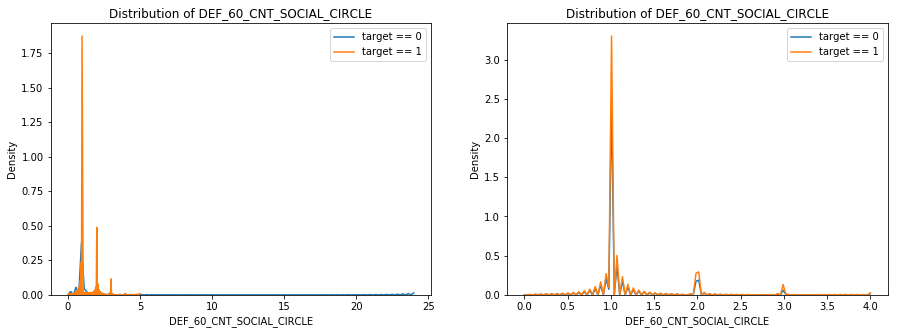

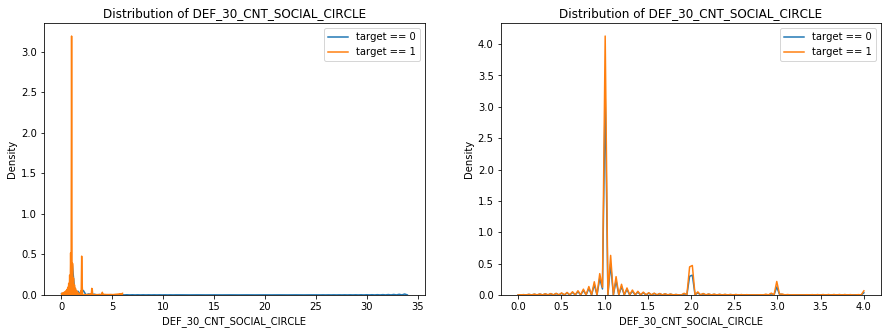

In [19]:
pt_1 = snskdeplot('DEF_60_CNT_SOCIAL_CIRCLE', 5)
pt_2 = snskdeplot('DEF_30_CNT_SOCIAL_CIRCLE', 5)

### Notes: 
There is high correlation between DEF_30_CNT_SOCIAL_CIRCLE and DEF_60_CNT_SOCIAL_CIRCLE, only keep 1 of them. There is perfect linear correlation between OBS_30_CNT_SOCIAL_CIRCLE and OBS_60_CNT_SOCIAL_CIRCLE, only keep 1.

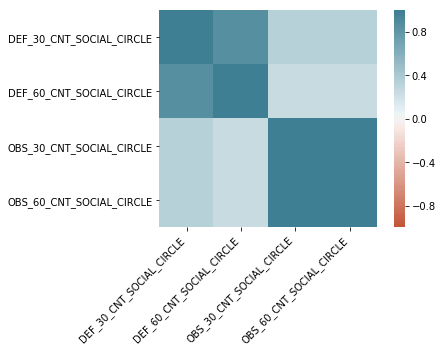

In [20]:
tt = data_all_2[['DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
                 'OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE']]
corr = tt.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

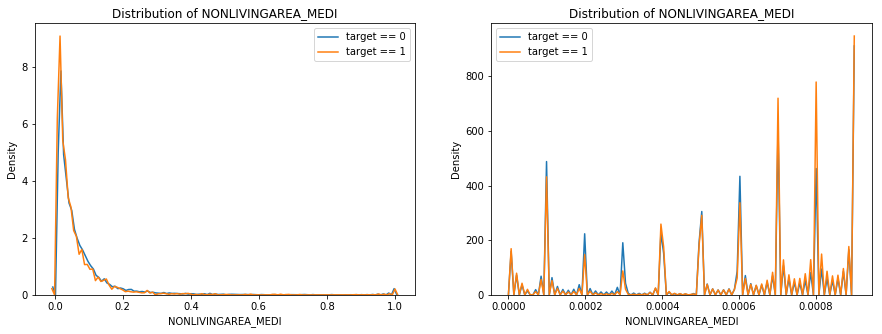

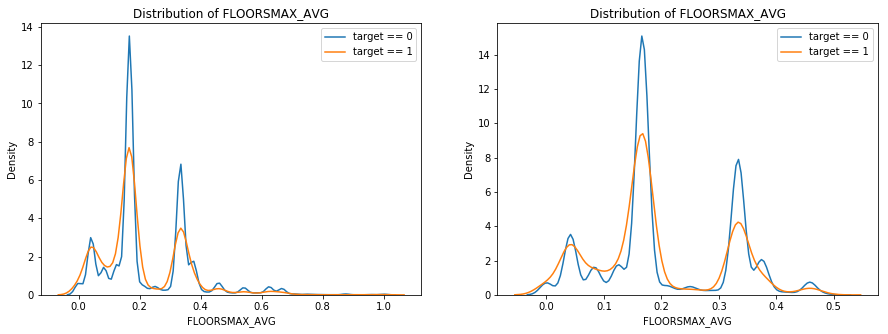

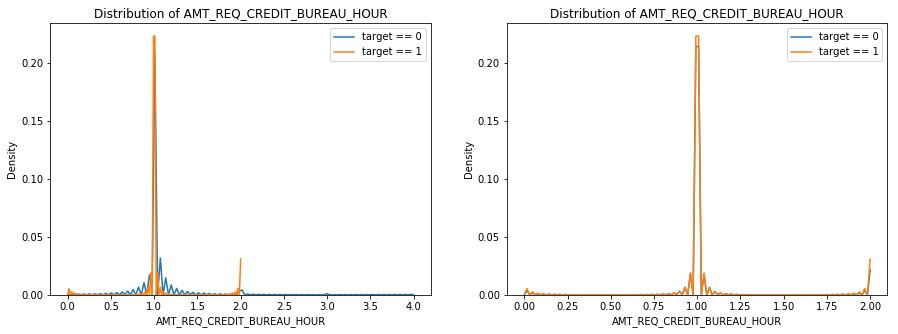

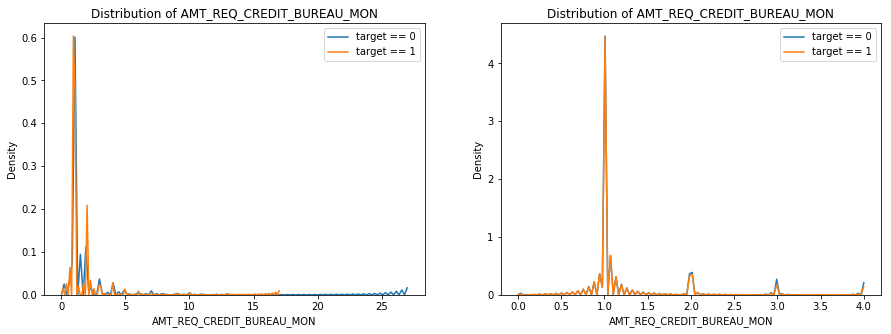

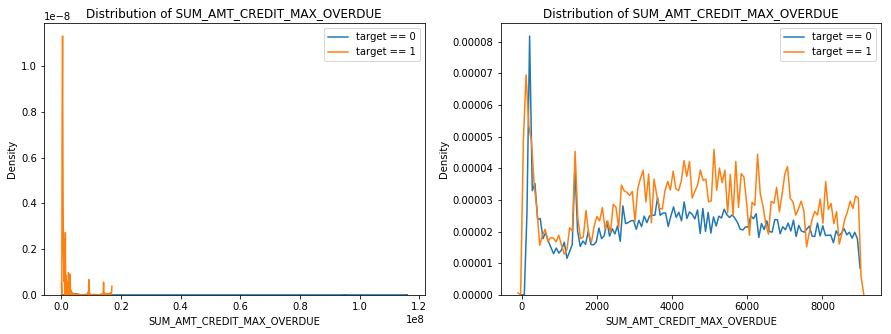

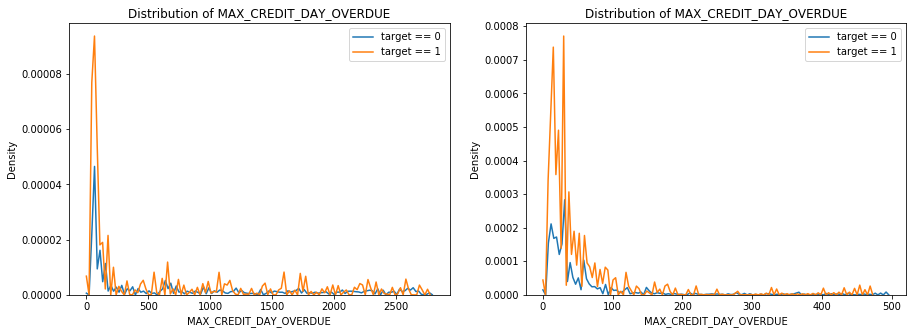

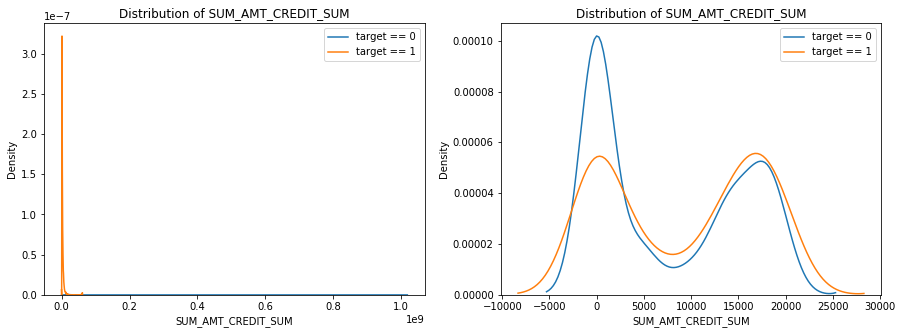

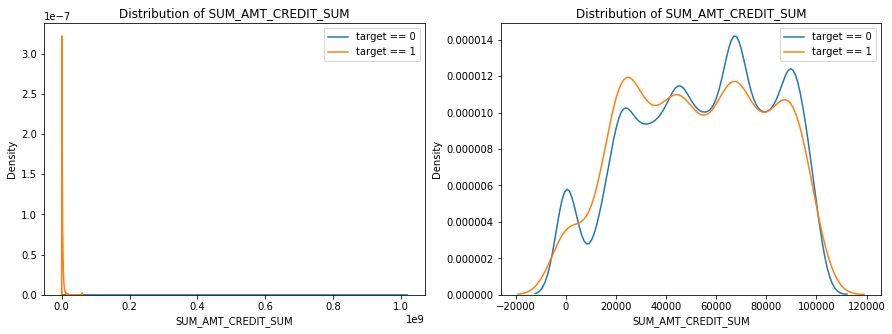

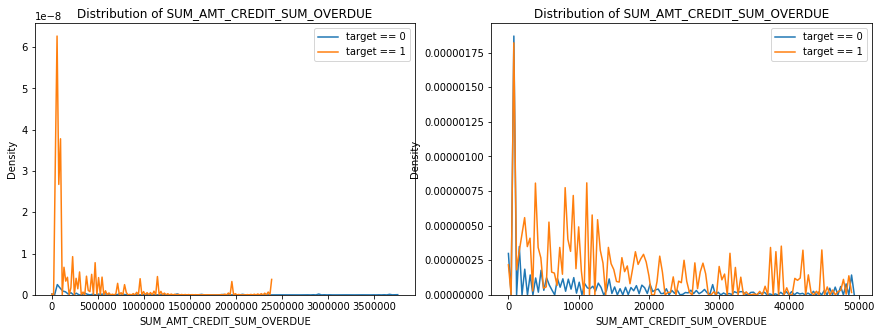

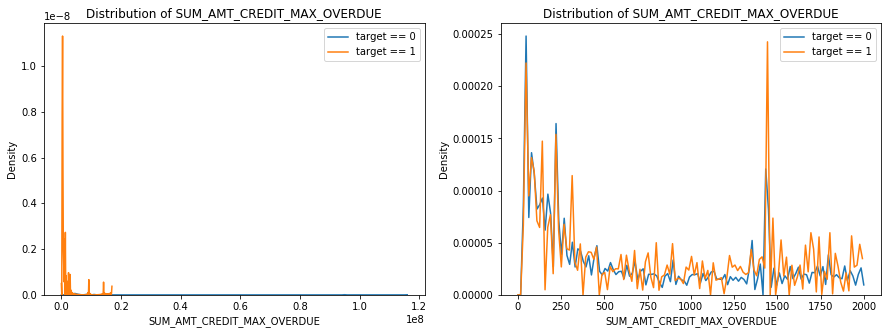

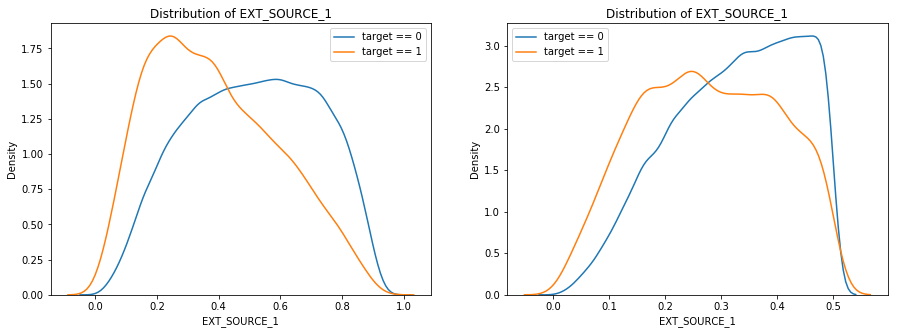

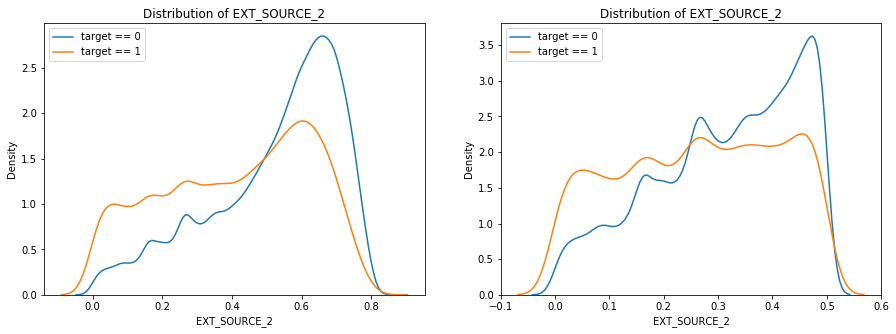

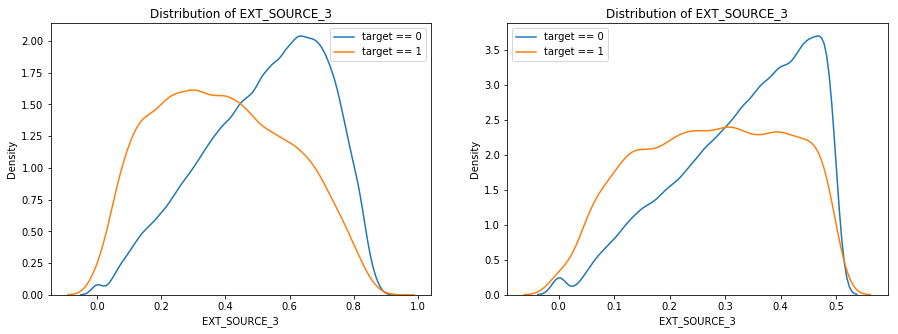

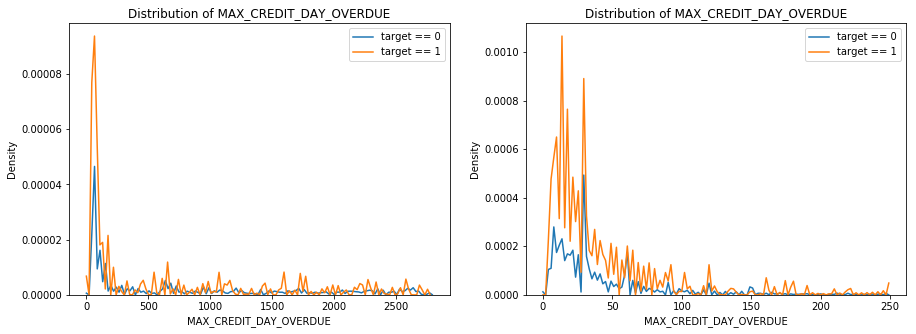

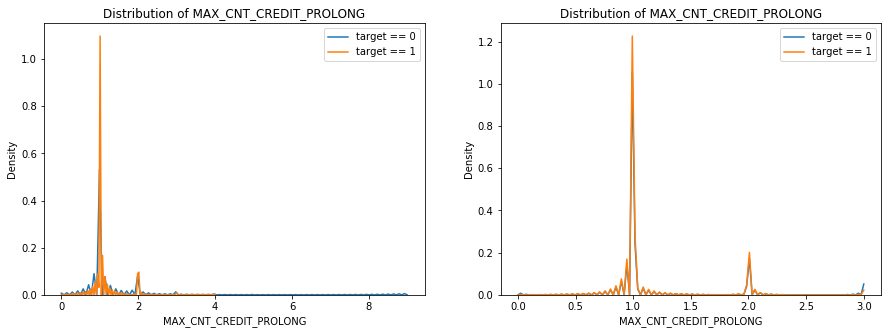

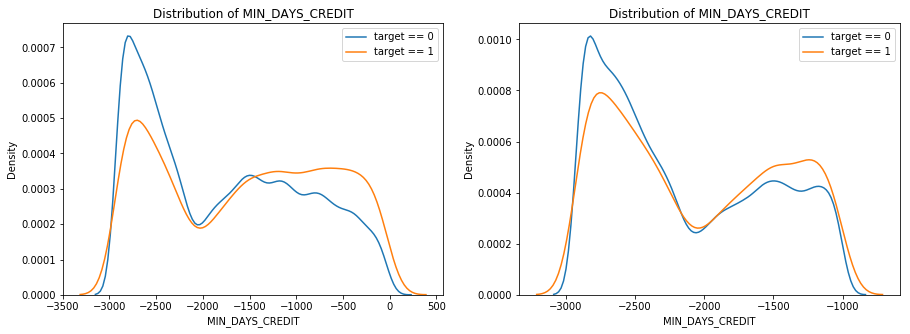

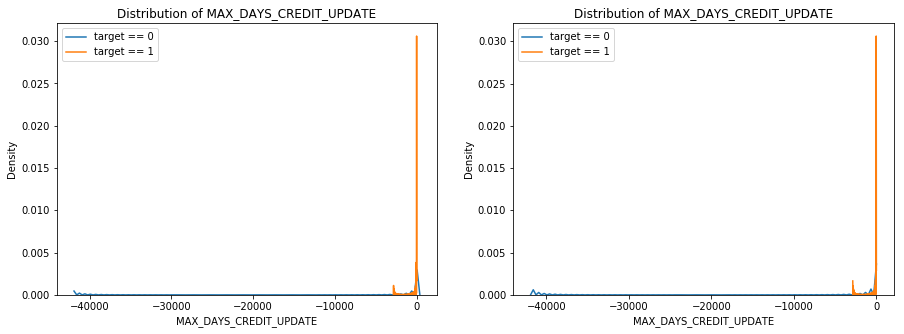

In [21]:
pt_3 = snskdeplot('NONLIVINGAREA_MEDI', 0.001)
pt_4 = snskdeplot('FLOORSMAX_AVG', 0.5)
pt_5 = snskdeplot('AMT_REQ_CREDIT_BUREAU_HOUR', 2.5)
pt_6 = snskdeplot('AMT_REQ_CREDIT_BUREAU_MON', 5)
pt_7 = snskdeplot('SUM_AMT_CREDIT_MAX_OVERDUE', 9000)
pt_8 = snskdeplot('MAX_CREDIT_DAY_OVERDUE', 500)
pt_9 = snskdeplot('SUM_AMT_CREDIT_SUM', 20000)
pt_10 = snskdeplot('SUM_AMT_CREDIT_SUM', 100000)
pt_11 = snskdeplot('SUM_AMT_CREDIT_SUM_OVERDUE', 50000)
pt_12 = snskdeplot('SUM_AMT_CREDIT_MAX_OVERDUE', 2000)
pt_13 = snskdeplot('EXT_SOURCE_1', 0.5)
pt_14 = snskdeplot('EXT_SOURCE_2', 0.5)
pt_15 = snskdeplot('EXT_SOURCE_3', 0.5)
pt_16 = snskdeplot('MAX_CREDIT_DAY_OVERDUE', 250)
pt_17 = snskdeplot('MAX_CNT_CREDIT_PROLONG', 4)
pt_18 = snskdeplot('MIN_DAYS_CREDIT', -1000)
pt_19 = snskdeplot('MAX_DAYS_CREDIT_UPDATE', 0)

#### No high correlations detected in the following groups of variables

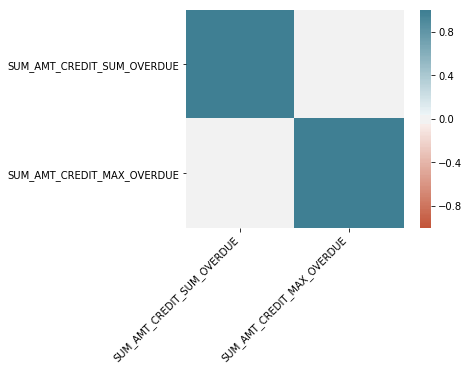

In [22]:
tt = data_all_2[['SUM_AMT_CREDIT_SUM_OVERDUE','SUM_AMT_CREDIT_MAX_OVERDUE']]
corr = tt.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

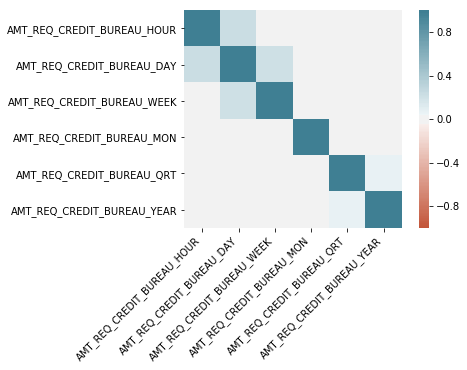

In [23]:
tt = data_all_2[['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']]
corr = tt.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

#### The following variables are skewed to the left, create visualizations by zooming in the right part.

In [24]:
def snskdeplot2(col, thresh):
    plt.figure(figsize = (15, 5))
    
    plt.subplot(121)
    # KDE plot of loans that were on time
    sns.kdeplot(data_all_2.loc[data_all_2['TARGET'] == 0, col], label = 'target == 0')

    # KDE plot of loans which were not on time / Default
    sns.kdeplot(data_all_2.loc[data_all_2['TARGET'] == 1, col], label = 'target == 1')

    # Labeling of plot
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f"Distribution of {col}")
    
    plt.subplot(122)
    
    ttt = data_all_2[['TARGET', col]][data_all_2[col] > thresh]
    # KDE plot of loans that were on time
    sns.kdeplot(ttt.loc[ttt['TARGET'] == 0, col], label = 'target == 0')

    # KDE plot of loans which were not on time / Default
    sns.kdeplot(ttt.loc[ttt['TARGET'] == 1, col], label = 'target == 1')

    # Labeling of plot
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f"Distribution of {col}")

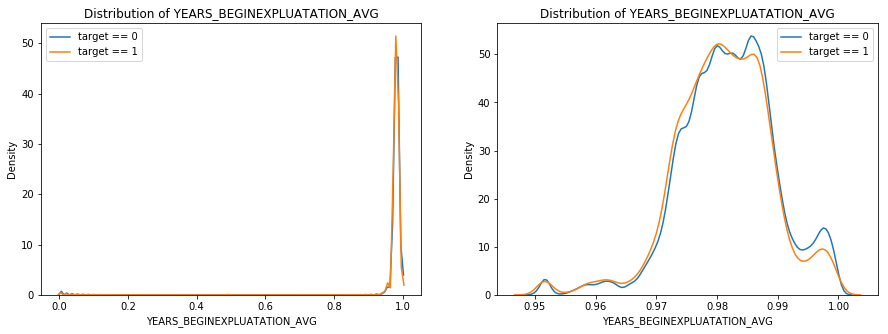

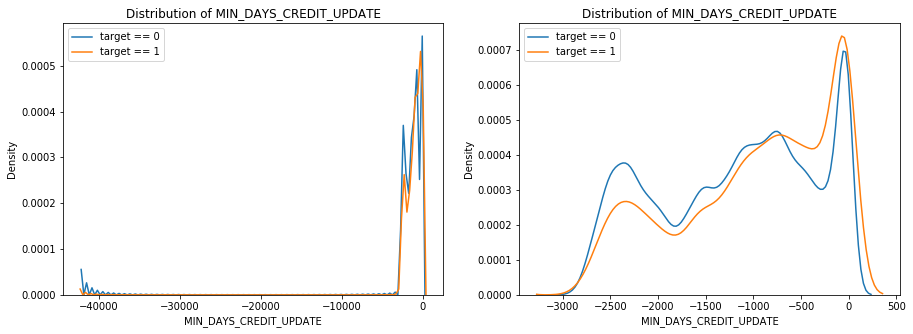

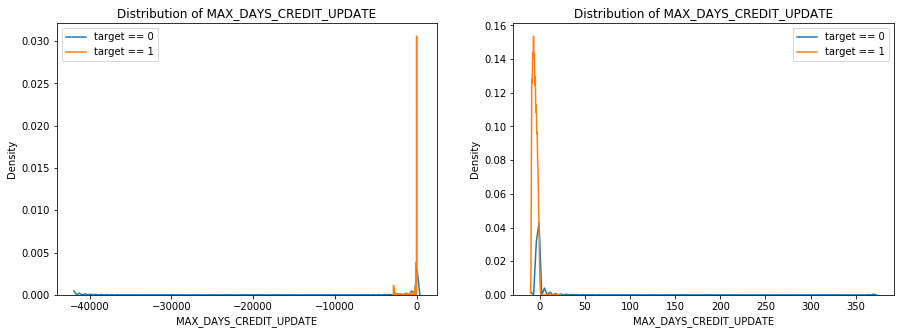

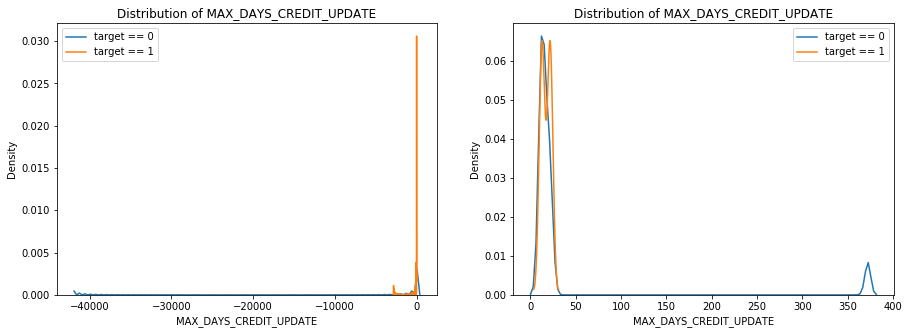

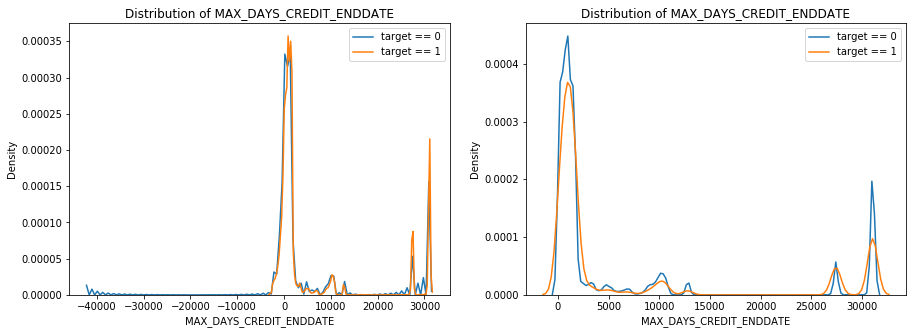

In [25]:
pt_19 = snskdeplot2('YEARS_BEGINEXPLUATATION_AVG', 0.95)
pt_20 = snskdeplot2('MIN_DAYS_CREDIT_UPDATE', -5000)
pt_21 = snskdeplot2('MAX_DAYS_CREDIT_UPDATE', -10)
pt_22 = snskdeplot2('MAX_DAYS_CREDIT_UPDATE', 0)
pt_23 = snskdeplot2('MAX_DAYS_CREDIT_ENDDATE', 0)

### Notes:
1. "DAYS_EMPLOYED" has values over 1000 years, which are apparently errors. Based on other age type of variables, they are all counting backwards, meaning the maximum should be 0, meaning current application date, so cap at 0.
2. 'MAX_DAYS_CREDIT_ENDDATE' is an aggregated field summarizing all SK_ID_PREV within the same SK_ID_CURR, using the max aggregation function. It means over all the previous applications within the same current application ID, the maximum remaining duration of Bureau credit at the time of application. This variable should be a positive number, but found negative values in the column, so floor the variable at 0. For missing values, first impute using the median.
3. 'MAX_DAYS_CREDIT_UPDATE' is an aggregated field summarizing all SK_ID_PREV within the same SK_ID_CURR, using the max aggregation function. It means over all the previous applications within the same current application ID, the maximum days before current application when the last information about the Credit Bureau credit come. This should be a negative number as it's counting backwards from the current application date. For all the positive numbers, define them as 0.
4. 'MIN_DAYS_CREDIT_UPDATE' is treated the same way as MAX_DAYS_CREDIT_UPDATE

#### The following "days" variables are converted to years to visualize the validity of value ranges.

In [26]:
def snskdeplot3(col):
    plt.figure(figsize = (8, 5))
        
    # KDE plot of loans that were on time
    sns.kdeplot(data_all_2.loc[data_all_2['TARGET'] == 0, col] / 365, label = 'target == 0')

    # KDE plot of loans which were not on time / Default
    sns.kdeplot(data_all_2.loc[data_all_2['TARGET'] == 1, col] / 365, label = 'target == 1')

    # Labeling of plot
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f'Distribution of {col} in YEARS')

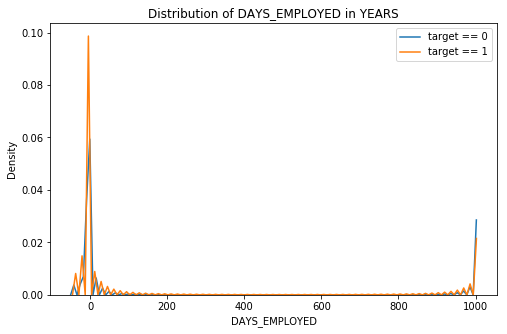

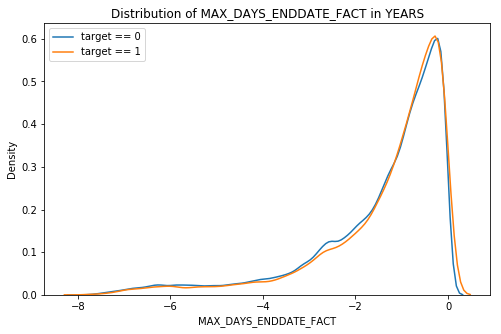

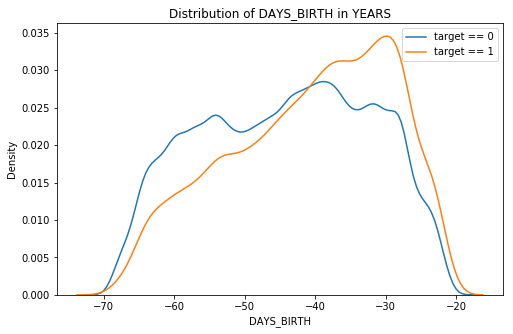

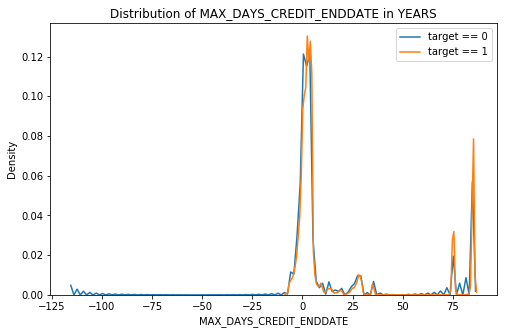

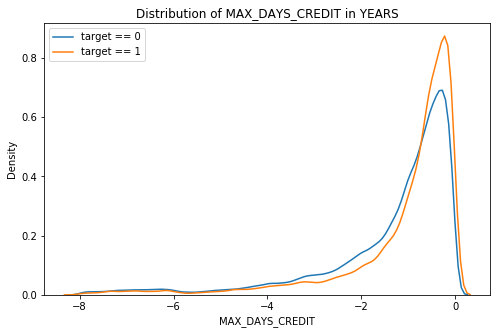

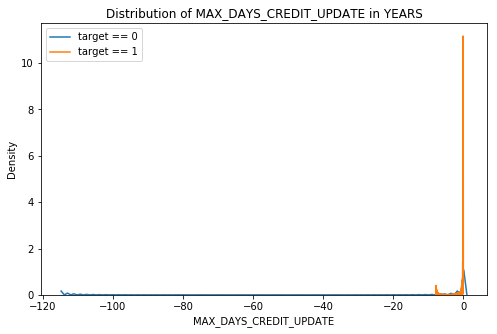

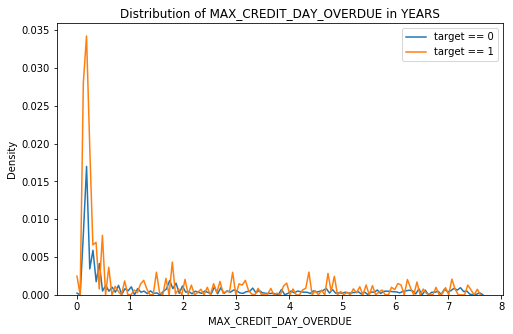

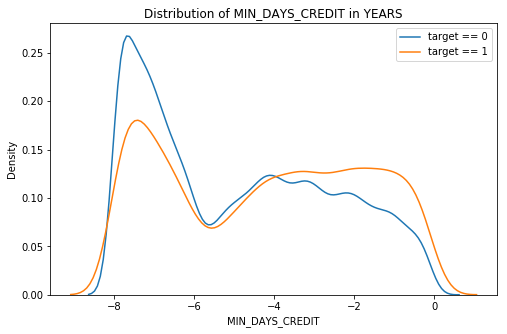

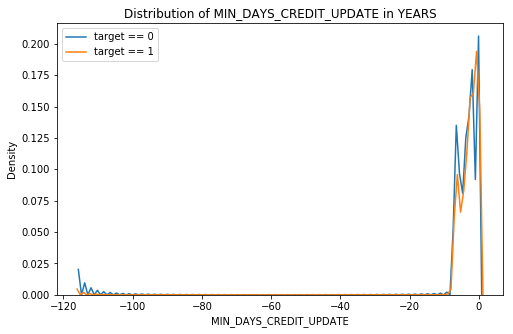

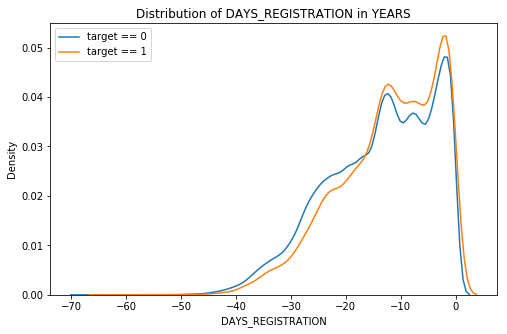

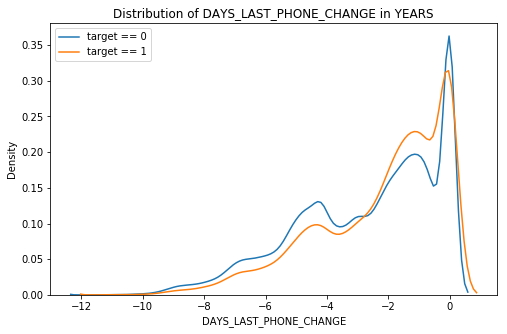

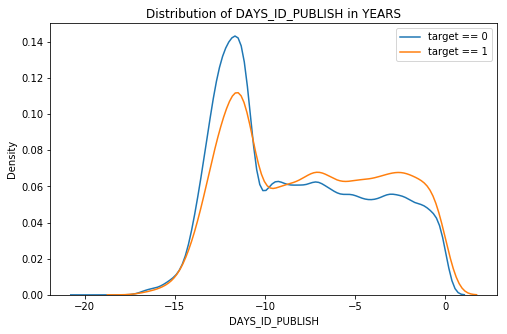

In [27]:
pt_24 = snskdeplot3('DAYS_EMPLOYED')
pt_25 = snskdeplot3('MAX_DAYS_ENDDATE_FACT')
pt_26 = snskdeplot3('DAYS_BIRTH')
pt_27 = snskdeplot3('MAX_DAYS_CREDIT_ENDDATE')
pt_28 = snskdeplot3('MAX_DAYS_CREDIT')
pt_29 = snskdeplot3('MAX_DAYS_CREDIT_UPDATE')
pt_30 = snskdeplot3('MAX_CREDIT_DAY_OVERDUE')
pt_31 = snskdeplot3('MIN_DAYS_CREDIT')
pt_32 = snskdeplot3('MIN_DAYS_CREDIT_UPDATE')
pt_33 = snskdeplot3('DAYS_REGISTRATION')
pt_34 = snskdeplot3('DAYS_LAST_PHONE_CHANGE')
pt_35 = snskdeplot3('DAYS_ID_PUBLISH')

#### Distributions of 'AMT_ANNUITY', 'AMT_CREDIT' and 'AMT_GOODS_PRICE' are skewed to the right, recommend to take log transformation to normalize the data.

In [28]:
# create a density plot for the amount of annuity and amount of credit of the default and non default groups 
# consider using log scale in modeling
def visualizations(col):
    plt.figure(figsize=(14,10))
    plt.suptitle(f'Amount / Log {col}', fontsize=18)

    plt.subplot(221)
    g = sns.distplot(data_all_2[(data_all_2['TARGET']==1) & (pd.notnull(data_all_2[col]))][col])
    g.set_title(f"{col} in Default Group", fontsize=16)
    g.set_xlabel(f"{col}", fontsize=14)
    g.set_ylabel("Probability", fontsize=14)

    plt.subplot(222)
    g1 = sns.distplot(data_all_2[(data_all_2['TARGET']==0) & (pd.notnull(data_all_2[col]))][col])
    g1.set_title(f"{col} in non Default Group", fontsize=16)
    g1.set_xlabel(f"{col}", fontsize=14)
    g1.set_ylabel("Probability", fontsize=14)

    plt.subplot(223)
    g = sns.distplot(np.log(data_all_2[(data_all_2['TARGET']==1) & (pd.notnull(data_all_2[col]))][col]))
    g.set_title(f"Log {col} in Default Group", fontsize=16)
    g.set_xlabel(f"Log {col}", fontsize=14)
    g.set_ylabel("Probability", fontsize=14)
    
    plt.subplot(224)
    g1 = sns.distplot(np.log(data_all_2[(data_all_2['TARGET']==0) & (pd.notnull(data_all_2[col]))][col]))
    g1.set_title(f"Log {col} in non Default Group", fontsize=16)
    g1.set_xlabel(f"Log {col}", fontsize=14)
    g1.set_ylabel("Probability", fontsize=14)

    plt.subplots_adjust(hspace = 0.4, wspace = 0.35, top = 0.9)
    plt.show()

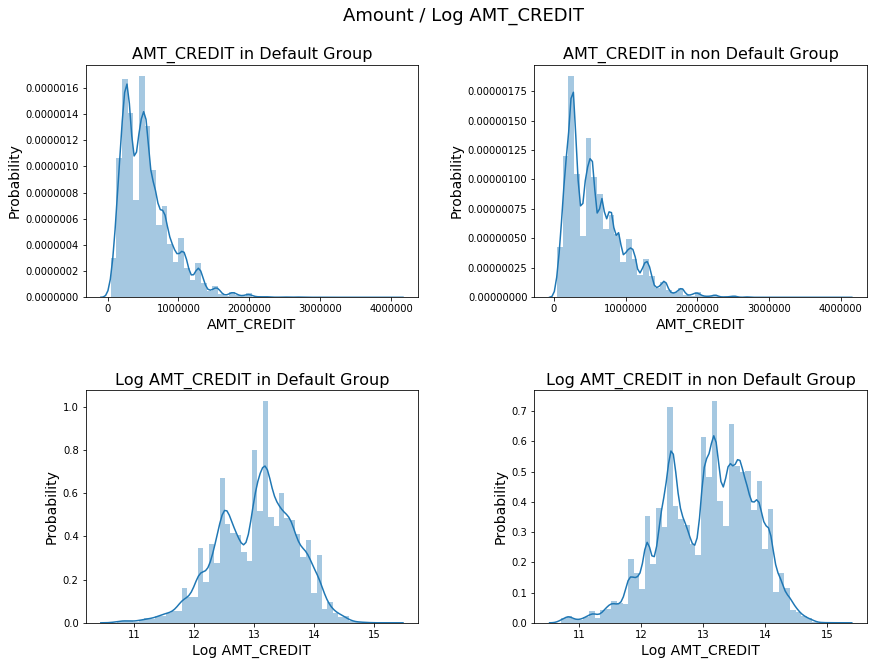

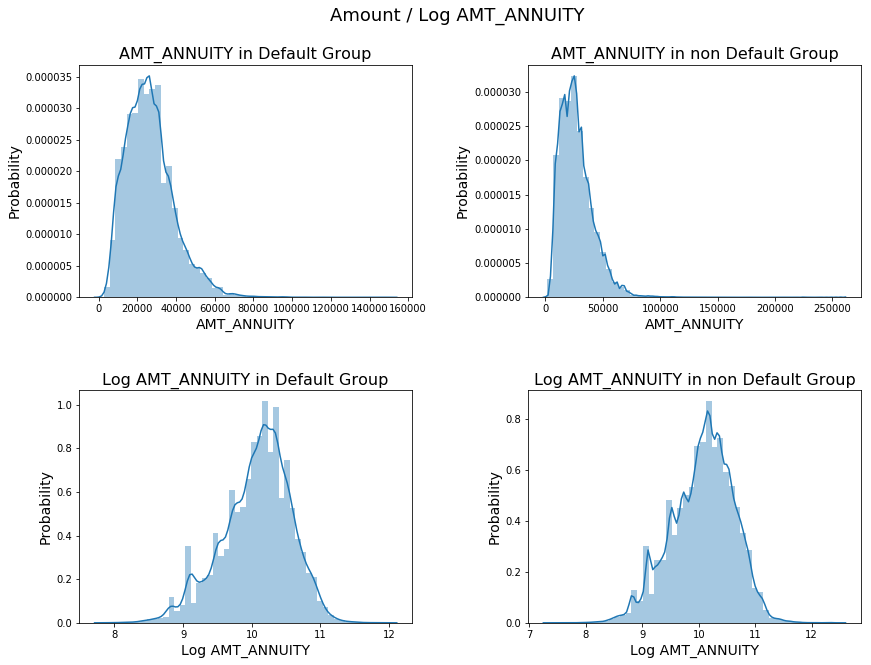

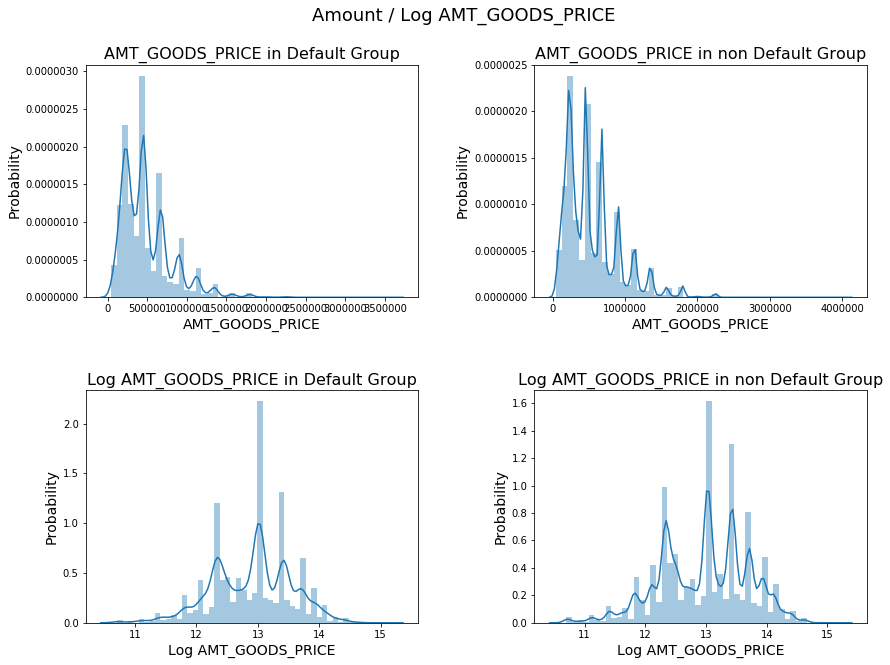

In [29]:
v1 = visualizations('AMT_CREDIT')
v2 = visualizations('AMT_ANNUITY')
v3 = visualizations('AMT_GOODS_PRICE')

### Notes:
The income for some records in the default group has some very large values, after investigations recommend to delete the outliers. After outlier removal, do log transformation to normalize the income data.

#### There's 1 record in the default group having total income larger than 100,000,000. If we include this data point in the model, it'll likely to classify extra high income records as default.

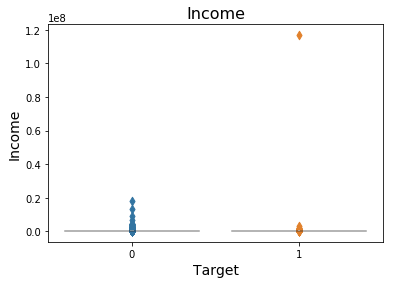

In [30]:
sns.boxenplot(x='TARGET', y=data_all_2['AMT_INCOME_TOTAL'], data=data_all_2)
plt.ylabel('Income', fontsize=14)
plt.xlabel('Target', fontsize=14)
plt.title('Income', fontsize=16)
plt.show()

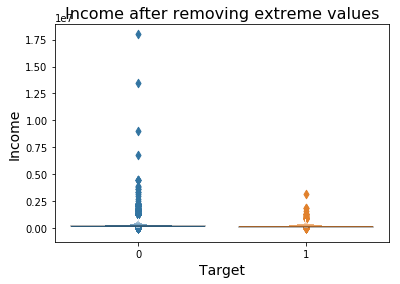

In [31]:
# Remove the extreme value in default group
sns.boxenplot(x='TARGET', y=data_all_2[data_all_2['AMT_INCOME_TOTAL']<=(10**8)]['AMT_INCOME_TOTAL'], data=data_all_2)
plt.ylabel('Income', fontsize=14)
plt.xlabel('Target', fontsize=14)
plt.title('Income after removing extreme values', fontsize=16)
plt.show()

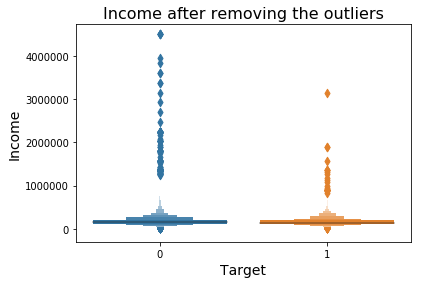

In [32]:
# Remove the 4 outliers in the non default group
sns.boxenplot(x='TARGET', y=data_all_2[data_all_2['AMT_INCOME_TOTAL']<=0.5*(10**7)]['AMT_INCOME_TOTAL'], data=data_all_2)
plt.ylabel('Income', fontsize=14)
plt.xlabel('Target', fontsize=14)
plt.title('Income after removing the outliers', fontsize=16)
plt.show()

In [33]:
# remove the 5 outliers and define income in both default and nondefault groups
income_in_default_gp = (data_all_2['AMT_INCOME_TOTAL']<=0.5*(10**7)) & (data_all_2['TARGET']==1)
income_in_nondefault_gp = (data_all_2['AMT_INCOME_TOTAL']<=0.5*(10**7)) & (data_all_2['TARGET']==0)

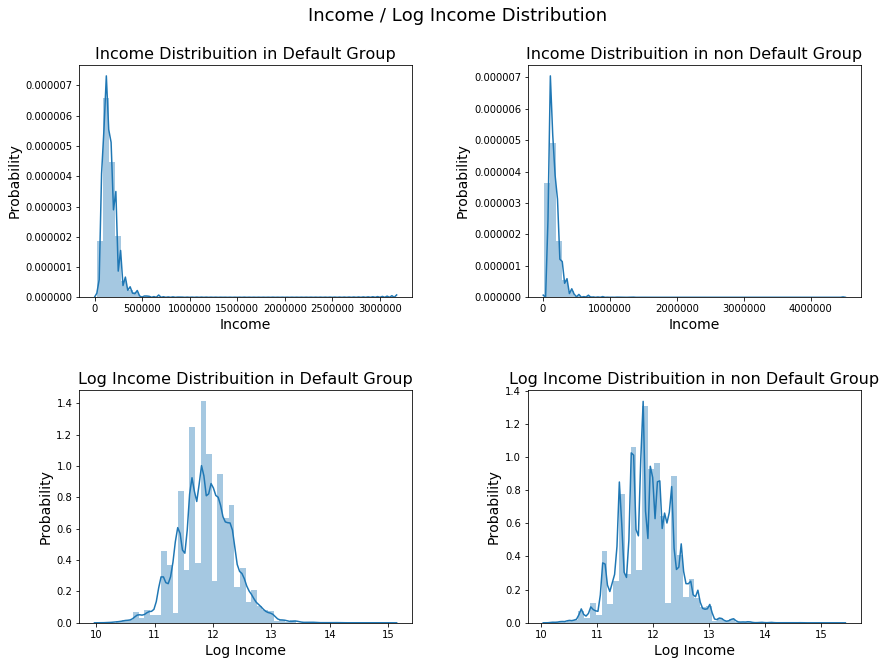

In [34]:
# create a density plot for the income of the 2 groups after outliers are removed
plt.figure(figsize=(14,10))
plt.suptitle('Income / Log Income Distribution', fontsize=18)

plt.subplot(221)
g = sns.distplot(data_all_2[income_in_default_gp]['AMT_INCOME_TOTAL'])
g.set_title("Income Distribuition in Default Group", fontsize=16)
g.set_xlabel("Income", fontsize=14)
g.set_ylabel("Probability", fontsize=14)

plt.subplot(222)
g1 = sns.distplot(data_all_2[income_in_nondefault_gp]['AMT_INCOME_TOTAL'])
g1.set_title("Income Distribuition in non Default Group", fontsize=16)
g1.set_xlabel("Income", fontsize=14)
g1.set_ylabel("Probability", fontsize=14)

# do a log transformation to make the distribution more normal
plt.subplot(223)
g = sns.distplot(np.log(data_all_2[income_in_default_gp]['AMT_INCOME_TOTAL']))
g.set_title("Log Income Distribuition in Default Group", fontsize=16)
g.set_xlabel("Log Income", fontsize=14)
g.set_ylabel("Probability", fontsize=14)

plt.subplot(224)
g1 = sns.distplot(np.log(data_all_2[income_in_nondefault_gp]['AMT_INCOME_TOTAL']))
g1.set_title("Log Income Distribuition in non Default Group", fontsize=16)
g1.set_xlabel("Log Income", fontsize=14)
g1.set_ylabel("Probability", fontsize=14)

plt.subplots_adjust(hspace = 0.4, wspace = 0.35, top = 0.9)
plt.show()

#### 'REGION_POPULATION_RELATIVE' variable has multiple modes, most of the clients live in lower population density places. Visually the distribution for the default and non default groups are similar.

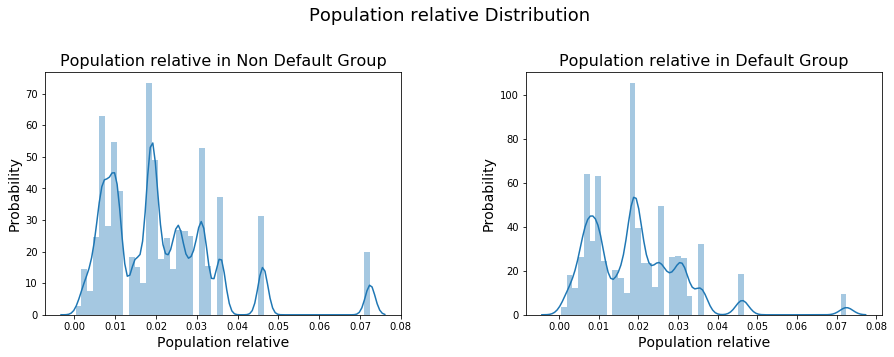

In [35]:
plt.figure(figsize=(15,5))
plt.suptitle('Population relative Distribution', fontsize=18)

plt.subplot(121)
g1 = sns.distplot(data_all_2.loc[data_all_2['TARGET'] == 0, 'REGION_POPULATION_RELATIVE']
[(pd.notnull(data_all_2.loc[data_all_2['TARGET'] == 0, 'REGION_POPULATION_RELATIVE']))])
g1.set_title('Population relative in Non Default Group', fontsize=16)
g1.set_xlabel('Population relative', fontsize=14)
g1.set_ylabel("Probability", fontsize=14)

plt.subplot(122)
g2 = sns.distplot(data_all_2.loc[data_all_2['TARGET'] == 1, 'REGION_POPULATION_RELATIVE']
[(pd.notnull(data_all_2.loc[data_all_2['TARGET'] == 1, 'REGION_POPULATION_RELATIVE']))])
g2.set_title('Population relative in Default Group', fontsize=16)
g2.set_xlabel('Population relative', fontsize=14)
g2.set_ylabel("Probability", fontsize=14)

plt.subplots_adjust(hspace = 0.4, wspace = 0.35, top = 0.8)
plt.show()

### Notes:
The distributions for _AVG, _MODE and _MEDI numeric variables are all kind of skewed, but since they are already normalized to range 0 to 1, no additional transformation is done to these variables. For missing values in these variables, can impute using the median.

The following variables are already removed in the dataset due to missing percentages over 60%. Can check list(mis_pct_ge60) to confirm that the following variables are in the exclusion list. 'YEARS_BUILD_AVG','COMMONAREA_AVG','FLOORSMIN_AVG','LIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_AVG',
'YEARS_BUILD_MODE','COMMONAREA_MODE','FLOORSMIN_MODE','LIVINGAPARTMENTS_MODE','NONLIVINGAPARTMENTS_MODE',
'YEARS_BUILD_MEDI','COMMONAREA_MEDI','FLOORSMIN_MEDI','LIVINGAPARTMENTS_MEDI','NONLIVINGAPARTMENTS_MEDI'

In the exercise below, only included those that are still present in the data set. 

In [36]:
def avg_mode_medi(suffix):
    prefix = ['APARTMENTS','BASEMENTAREA','YEARS_BEGINEXPLUATATION','ELEVATORS','ENTRANCES',
              'FLOORSMAX','LANDAREA','LIVINGAREA','NONLIVINGAREA']
    
    for i in prefix:
        varname = i + suffix
    
        plt.figure(figsize=(15,5))
        plt.suptitle(f"{varname} Distribution", fontsize=18)

        plt.subplot(121)
        g1 = sns.distplot(data_all_2.loc[data_all_2['TARGET'] == 0, varname]
                          [(pd.notnull(data_all_2.loc[data_all_2['TARGET'] == 0, varname]))])
        g1.set_title(f"{varname} in Non Default Group", fontsize=16)
        g1.set_xlabel(f"{varname}", fontsize=14)
        g1.set_ylabel("Probability", fontsize=14)

        plt.subplot(122)
        g2 = sns.distplot(data_all_2.loc[data_all_2['TARGET'] == 1, varname]
                          [(pd.notnull(data_all_2.loc[data_all_2['TARGET'] == 1, varname]))])
        g2.set_title(f"{varname} in Default Group", fontsize=16)
        g2.set_xlabel(f"{varname}", fontsize=14)
        g2.set_ylabel("Probability", fontsize=14)
    
        plt.subplots_adjust(hspace = 0.4, wspace = 0.35, top = 0.8)
        plt.show()

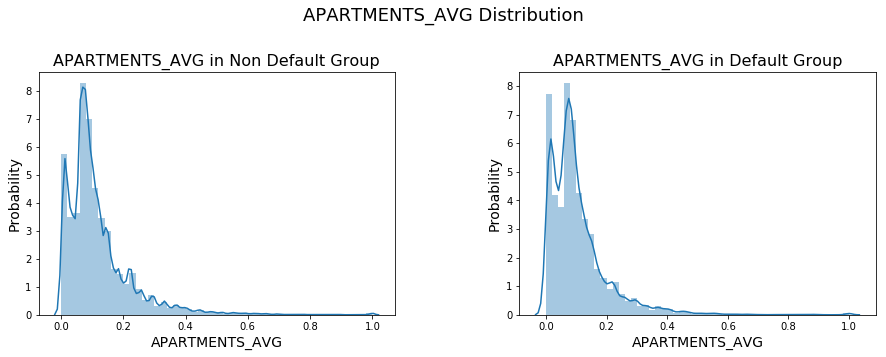

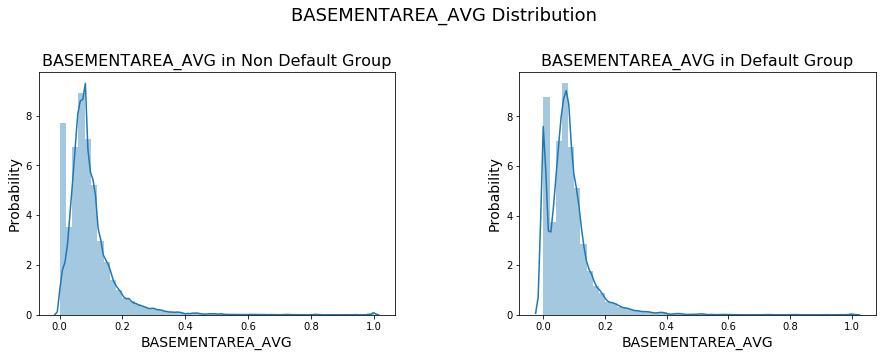

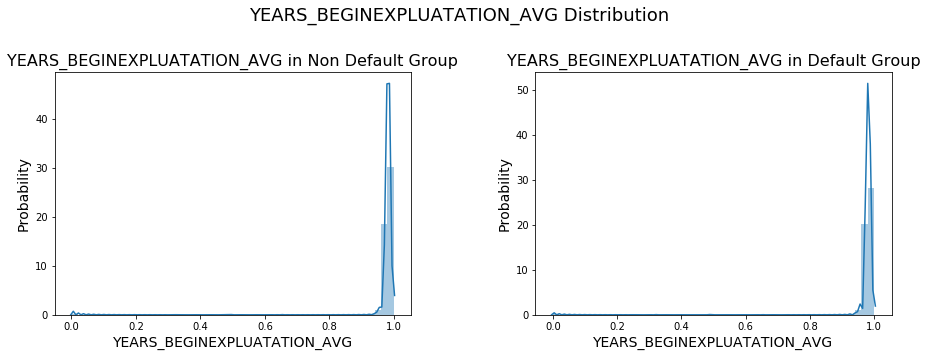

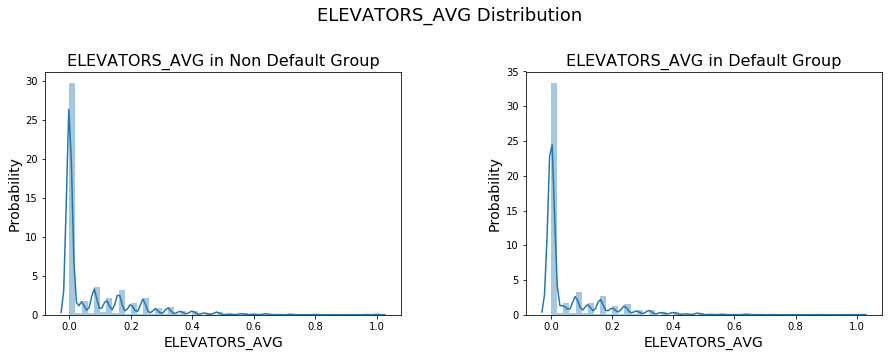

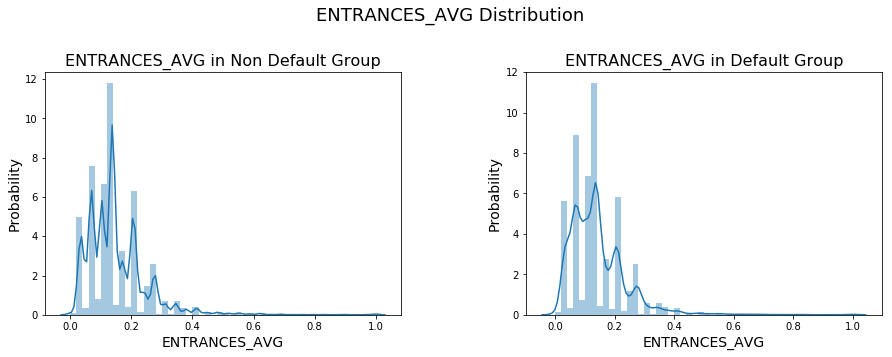

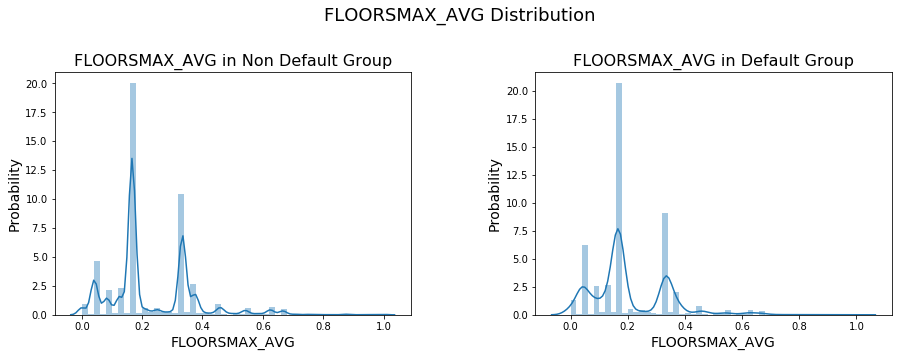

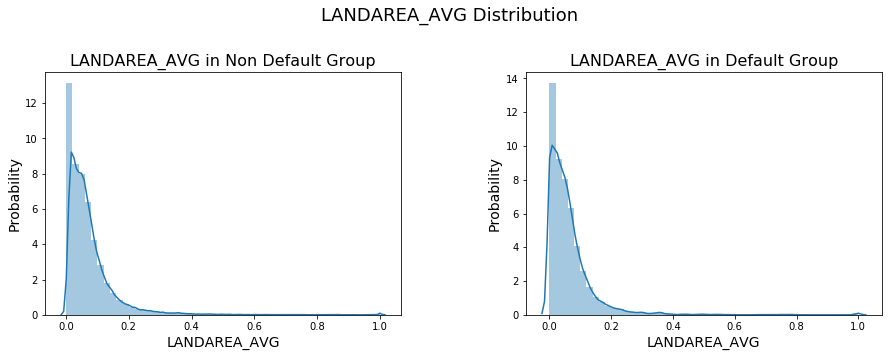

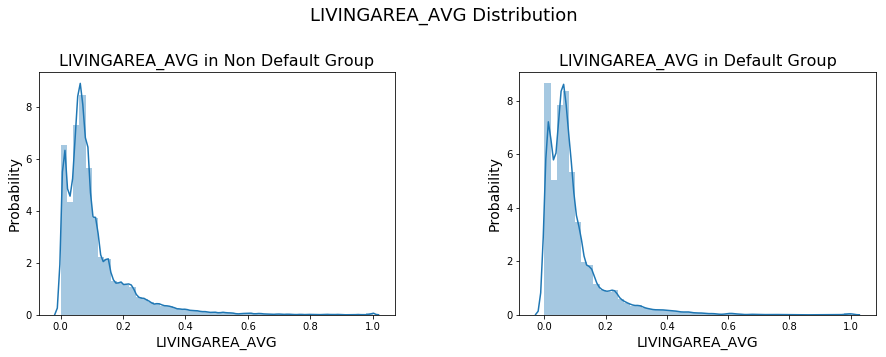

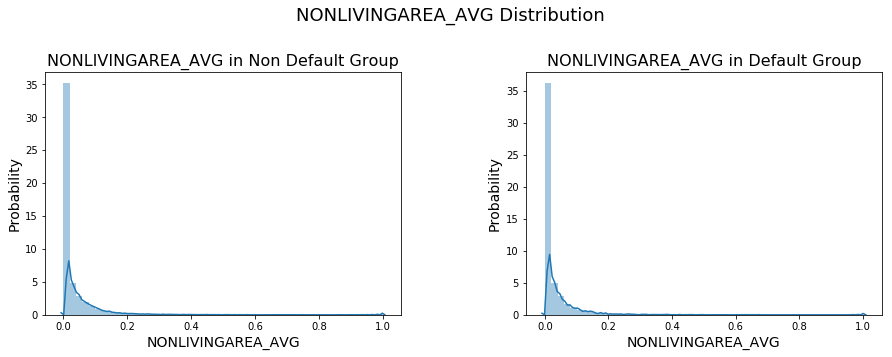

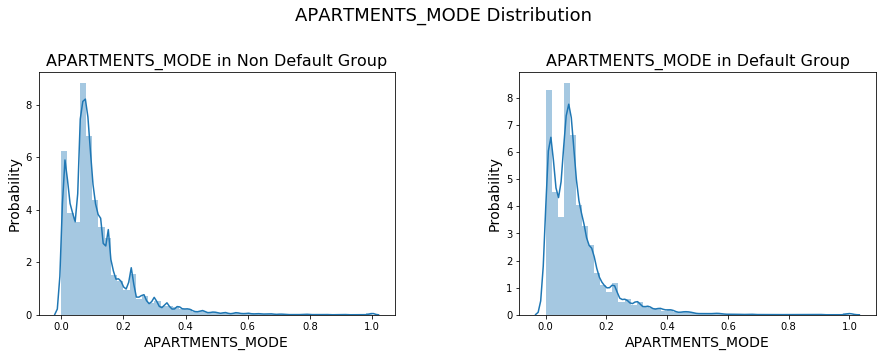

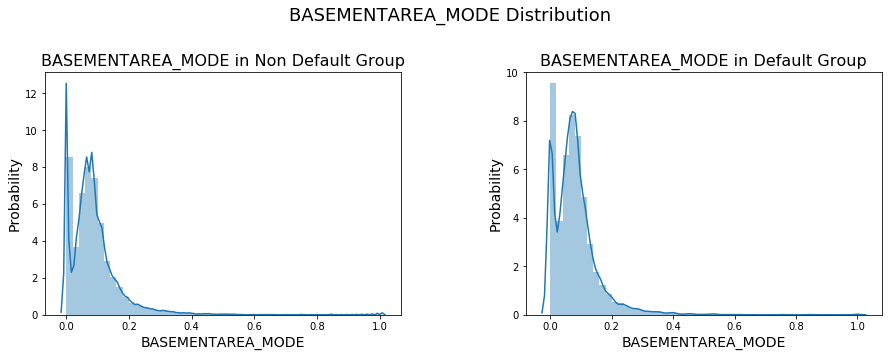

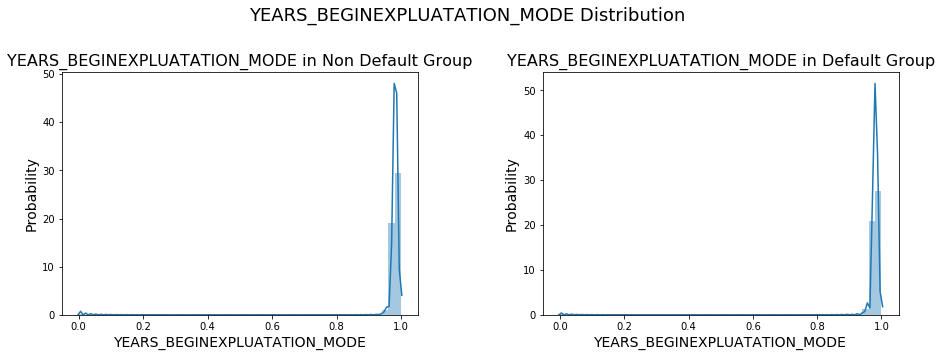

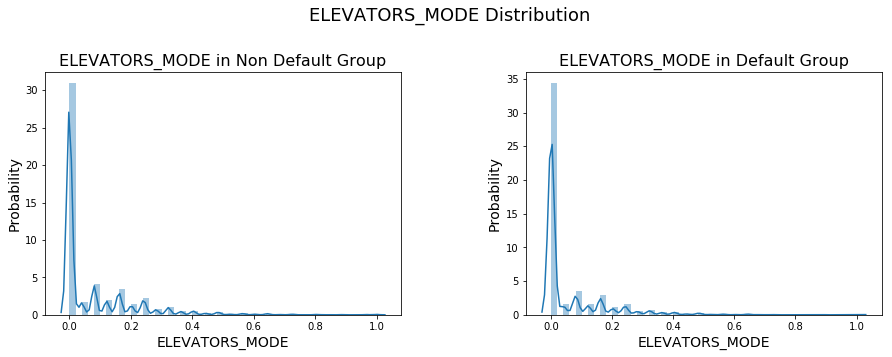

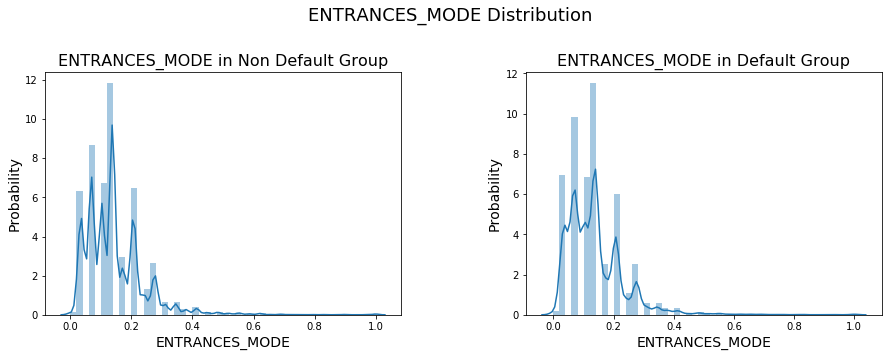

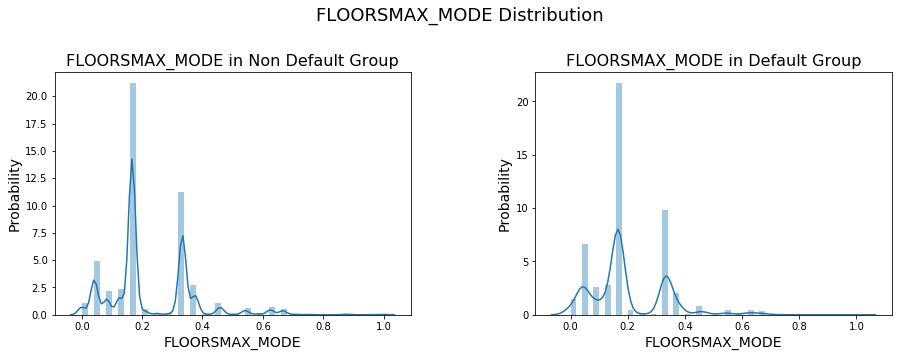

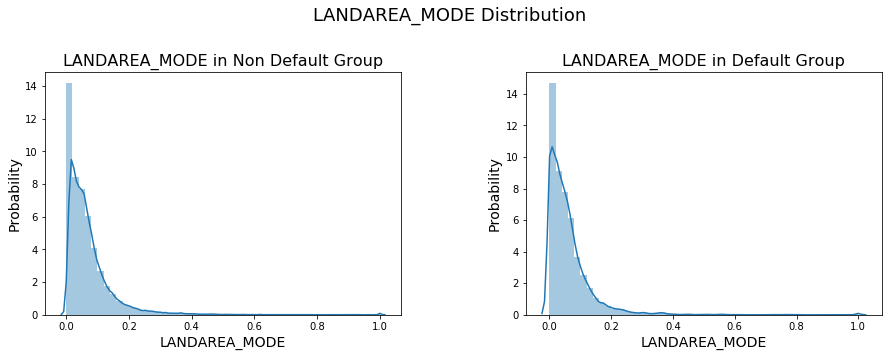

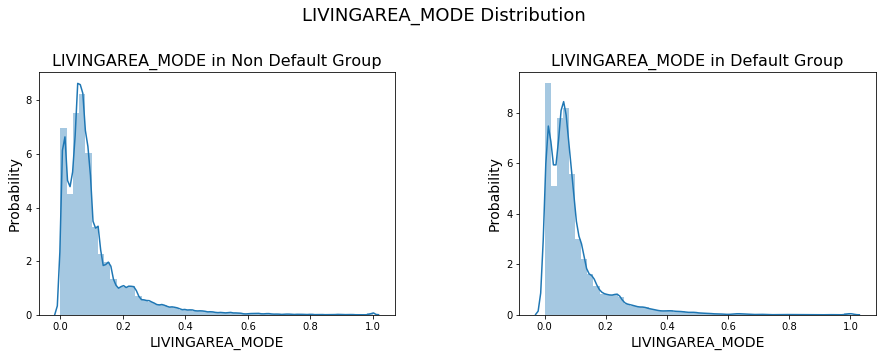

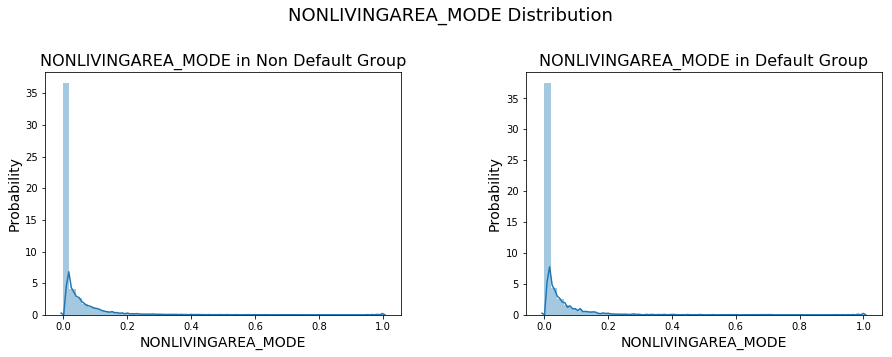

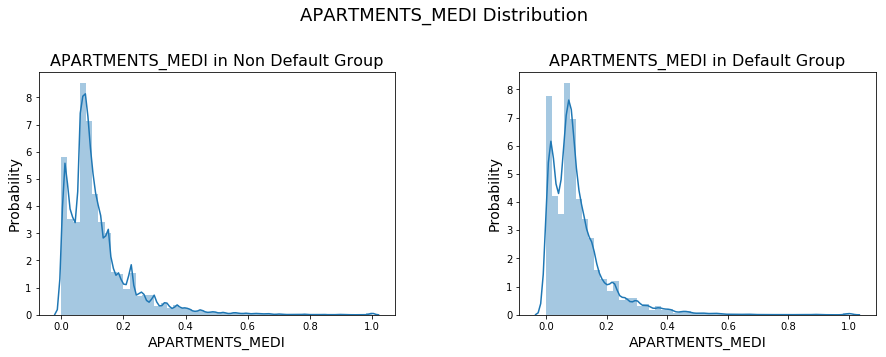

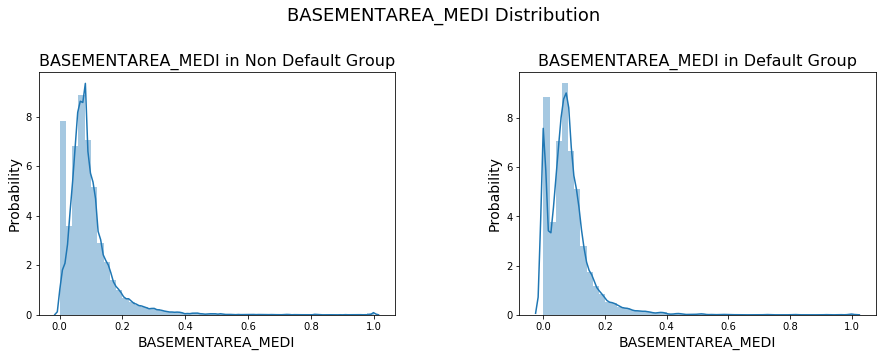

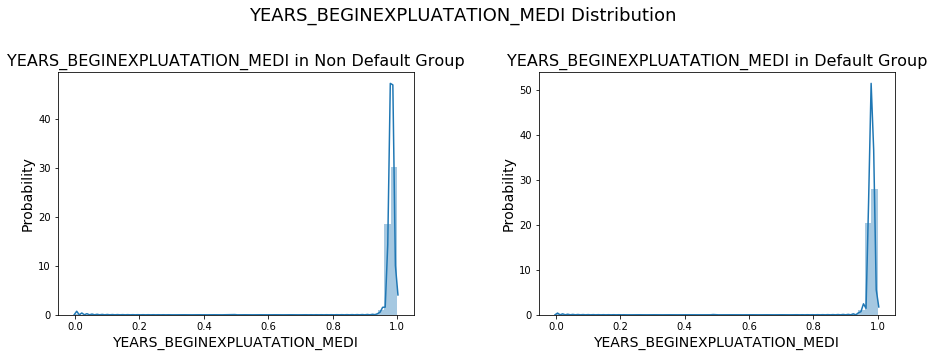

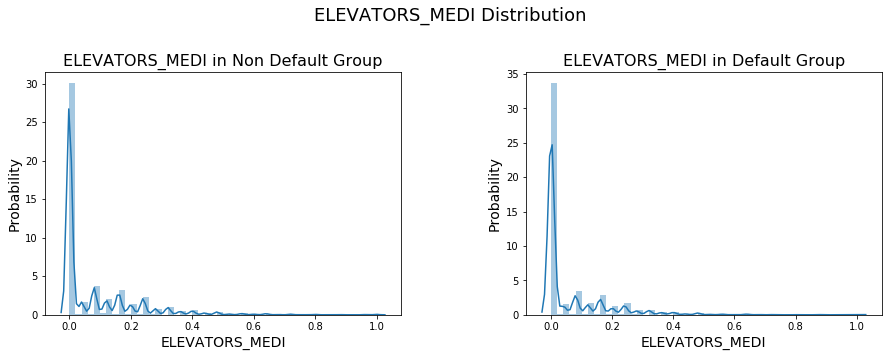

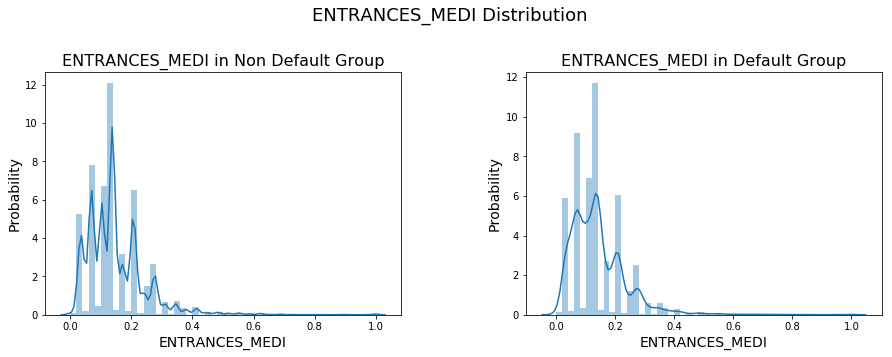

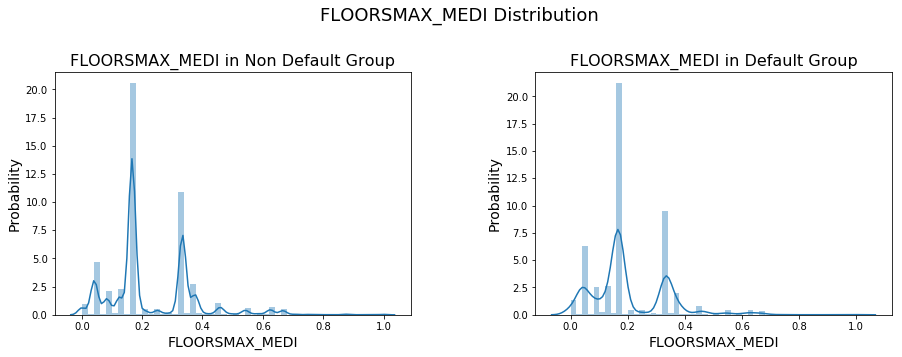

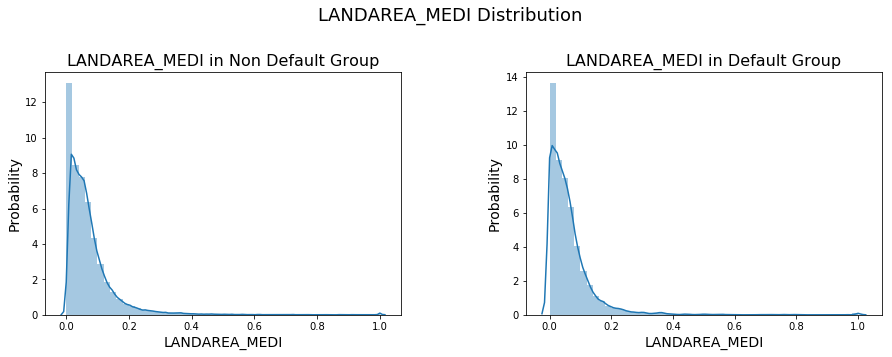

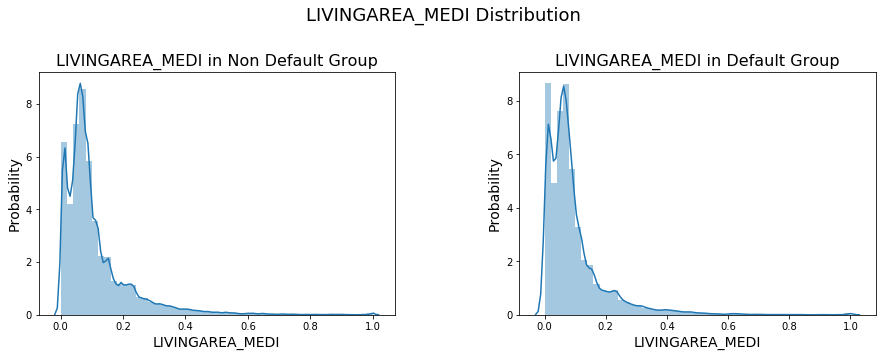

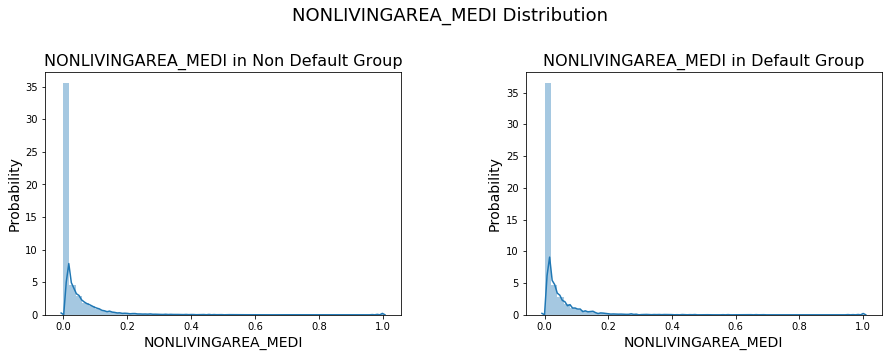

In [37]:
# _AVG
avg_plots = avg_mode_medi('_AVG')
# _MODE
mode_plots = avg_mode_medi('_MODE')
# _MEDI
medi_plots = avg_mode_medi('_MEDI')

#### Correlations between the _AVG, _MODE and _MEDI variables. Some groups of variables are highly correlated with some groups, for example, 'APARTMENTS' variables are highly correlated with 'LIVINGAREA' variables. At this point we don't remove any one of them.

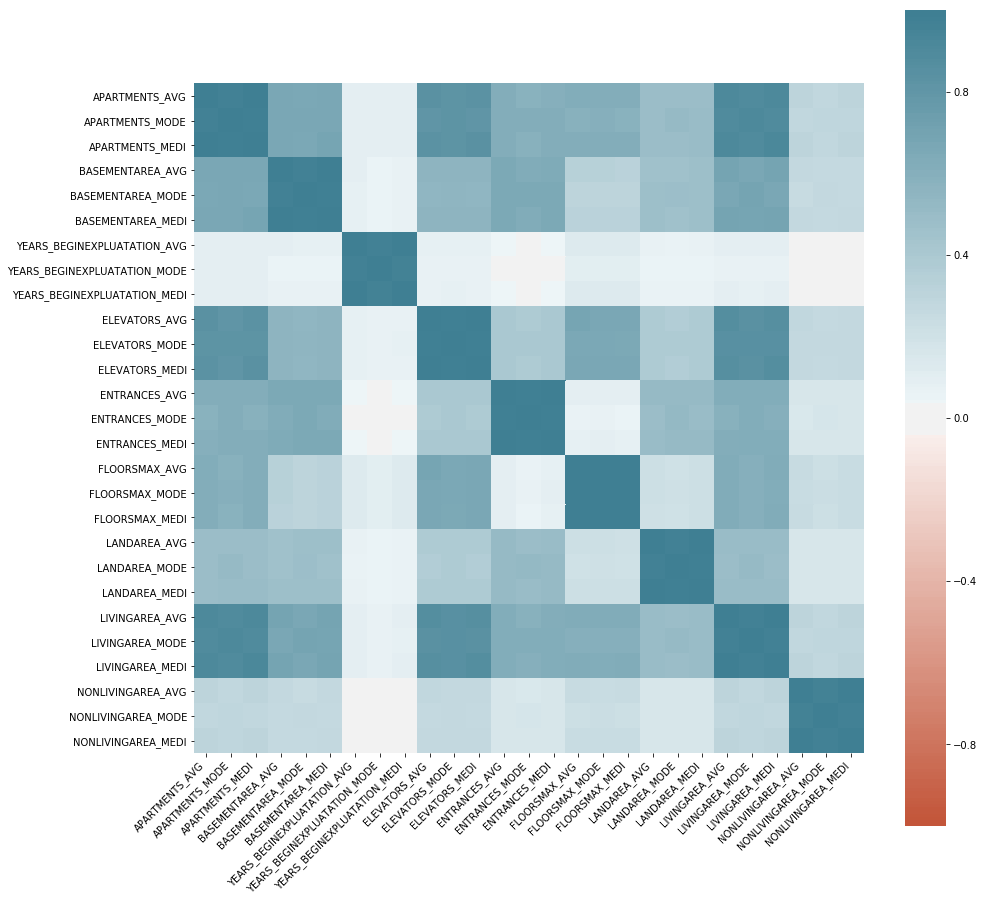

In [38]:
tt = data_all_2[['APARTMENTS_AVG','APARTMENTS_MODE','APARTMENTS_MEDI',
                'BASEMENTAREA_AVG','BASEMENTAREA_MODE','BASEMENTAREA_MEDI',
                'YEARS_BEGINEXPLUATATION_AVG','YEARS_BEGINEXPLUATATION_MODE','YEARS_BEGINEXPLUATATION_MEDI',
                'ELEVATORS_AVG','ELEVATORS_MODE','ELEVATORS_MEDI',
                'ENTRANCES_AVG','ENTRANCES_MODE','ENTRANCES_MEDI',
                'FLOORSMAX_AVG','FLOORSMAX_MODE','FLOORSMAX_MEDI',
                'LANDAREA_AVG','LANDAREA_MODE','LANDAREA_MEDI',
                'LIVINGAREA_AVG','LIVINGAREA_MODE','LIVINGAREA_MEDI',
                'NONLIVINGAREA_AVG','NONLIVINGAREA_MODE','NONLIVINGAREA_MEDI',]]
corr = tt.corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

#### At this point there are still some other numeric variables coming out of aggregation fields. We pick a few and make some KDE plots to visualize their distributions. All of these variables are skewed to the right, for simpilcity, recommend to use median to impute missing values in these variables.

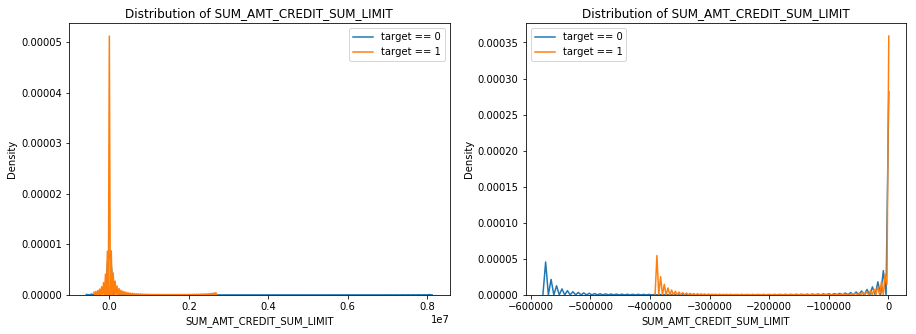

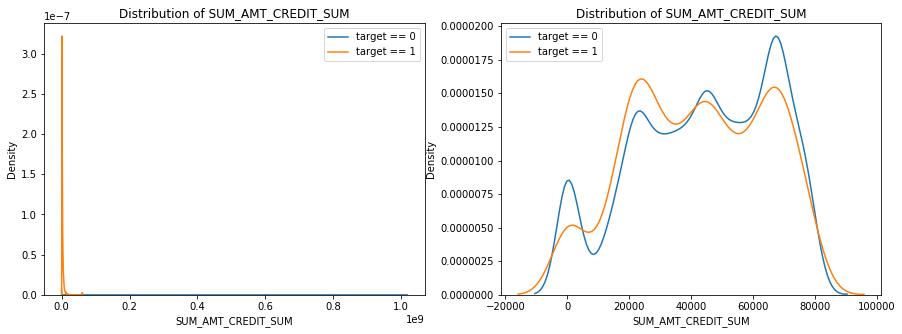

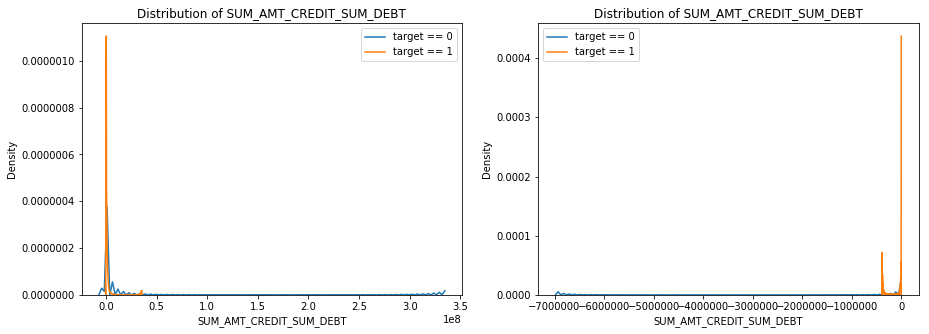

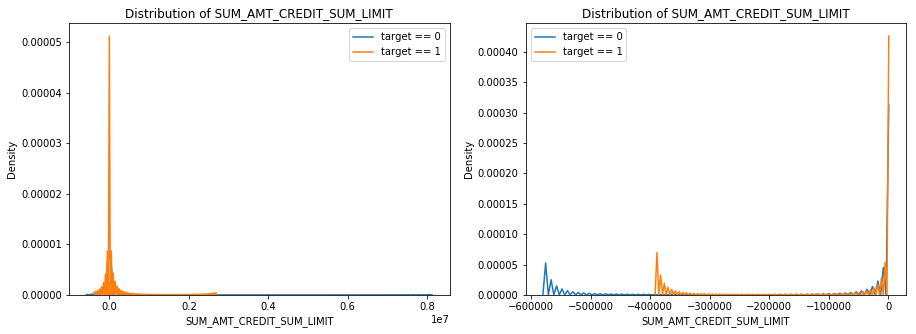

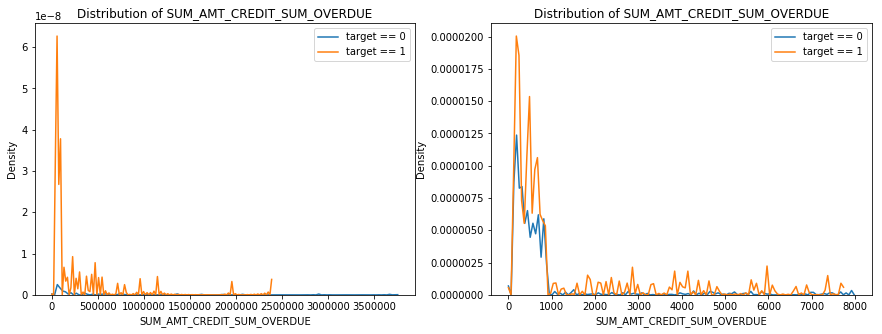

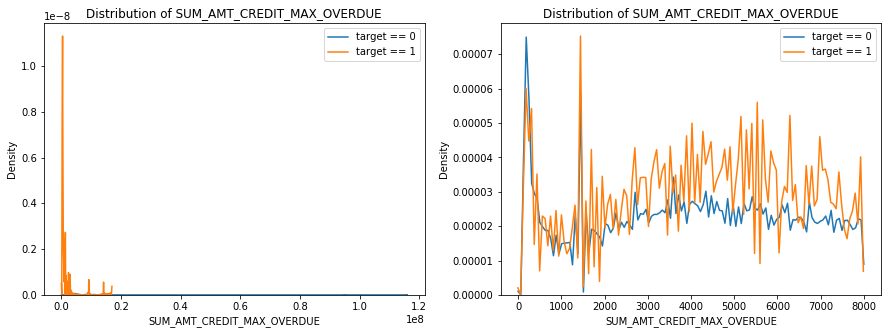

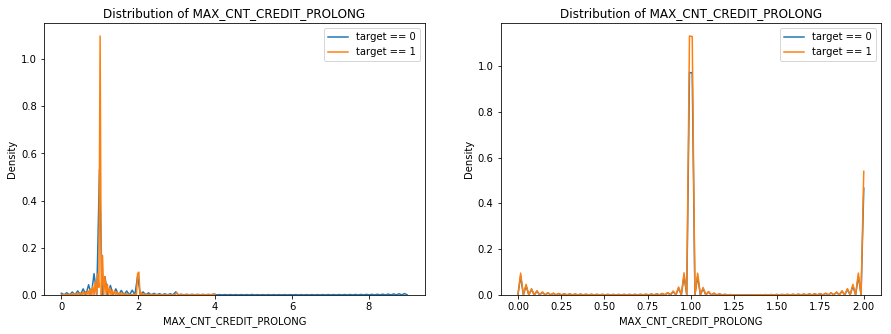

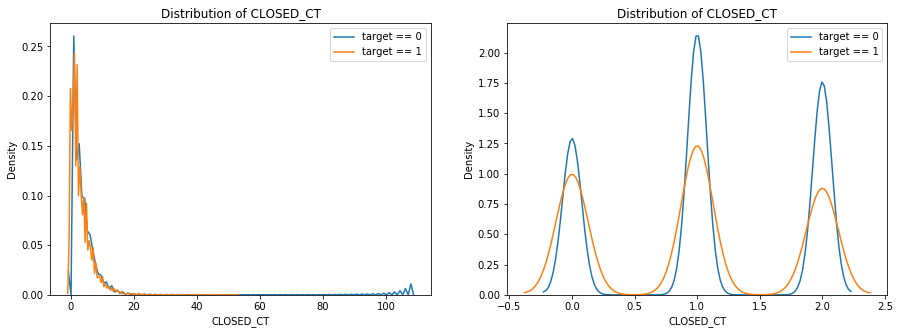

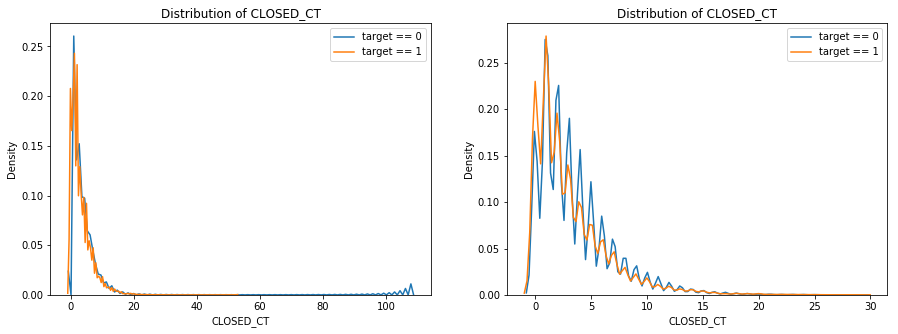

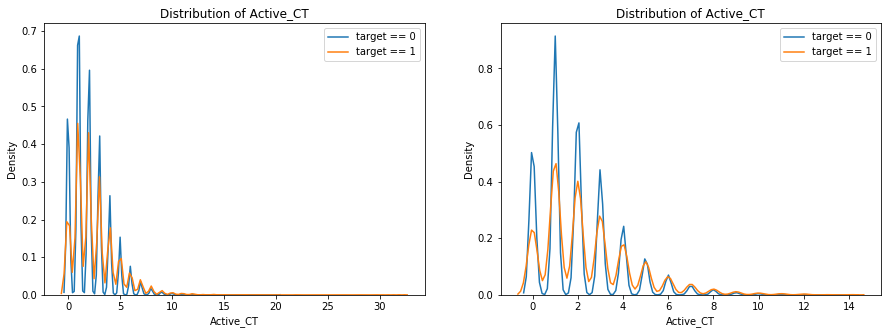

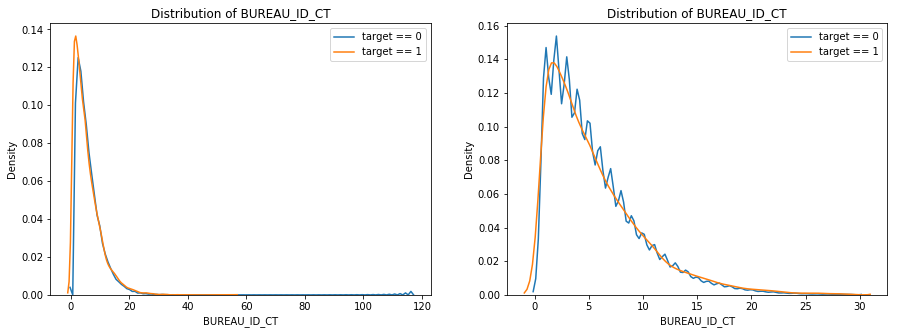

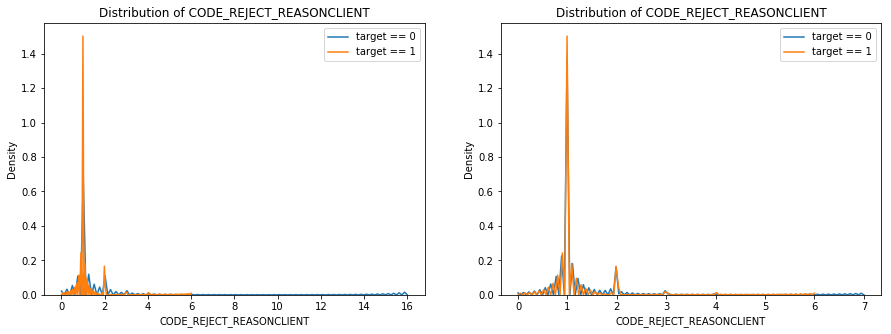

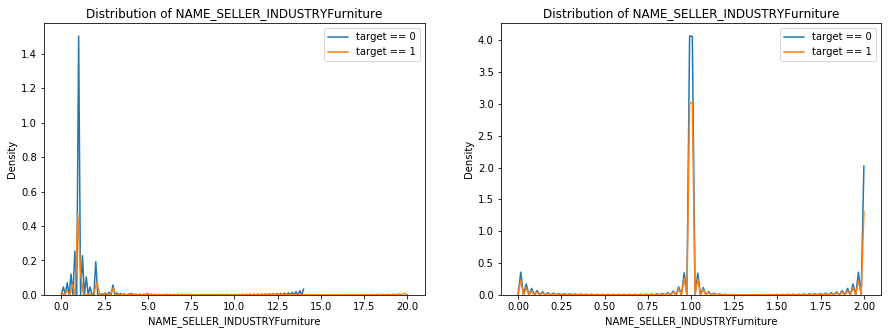

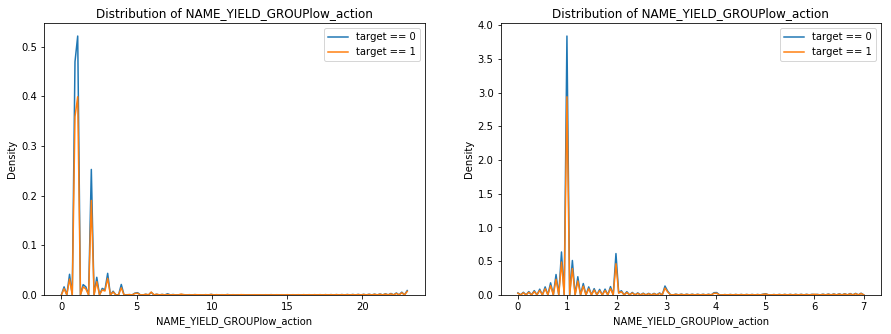

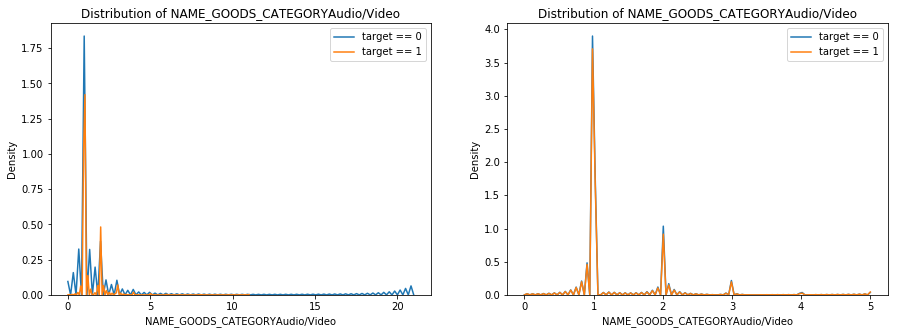

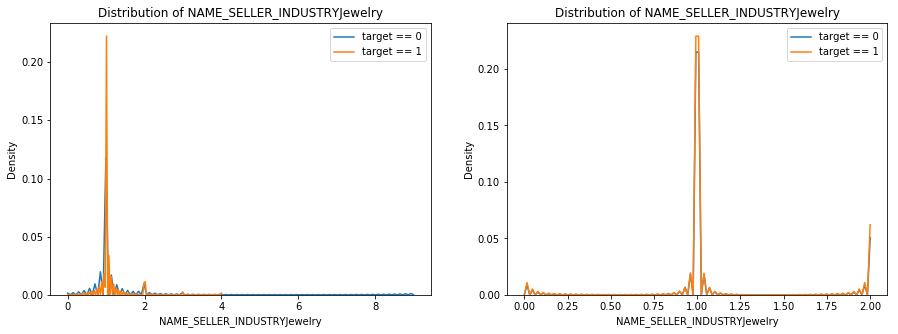

In [39]:
snskdeplot('SUM_AMT_CREDIT_SUM_LIMIT', 800)
snskdeplot('SUM_AMT_CREDIT_SUM', 80000) 
snskdeplot('SUM_AMT_CREDIT_SUM_DEBT', 500)
snskdeplot('SUM_AMT_CREDIT_SUM_LIMIT', 500)
snskdeplot('SUM_AMT_CREDIT_SUM_OVERDUE', 8000)
snskdeplot('SUM_AMT_CREDIT_MAX_OVERDUE', 8000)
snskdeplot('MAX_CNT_CREDIT_PROLONG', 3)
snskdeplot('CLOSED_CT', 3)
snskdeplot('CLOSED_CT', 30)
snskdeplot('Active_CT', 15)
snskdeplot('BUREAU_ID_CT', 30)
snskdeplot('CODE_REJECT_REASONCLIENT', 8)
snskdeplot('NAME_SELLER_INDUSTRYFurniture', 3)
snskdeplot('NAME_YIELD_GROUPlow_action', 8)
snskdeplot('NAME_GOODS_CATEGORYAudio/Video', 6)
snskdeplot('NAME_SELLER_INDUSTRYJewelry', 3)

## 7. Data transformation, high correlation column removal and outlier removal

In [40]:
data_all_3 = data_all_2.copy()

# remove 5 outliers (4 in non default group, 1 in default group), then do log transformation
data_all_3 = data_all_3[(data_all_3['AMT_INCOME_TOTAL']<=0.5*(10**7))]

# remove gender = XNA
data_all_3 = data_all_3[(data_all_3['CODE_GENDERXNACURR'] == 0)]

# drop the following variables due to high correlations with other variables
droplist = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'CODE_GENDERXNACURR']
data_all_3.drop(droplist, axis=1, inplace=True)

# first impute using median if there are missing values, then cap at 0 for the following 3 variables 
data_all_3.loc[data_all_3['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0

data_all_3['MAX_DAYS_CREDIT_UPDATE'] = data_all_3['MAX_DAYS_CREDIT_UPDATE'].fillna(data_all_3['MAX_DAYS_CREDIT_UPDATE'].median())
data_all_3.loc[data_all_3['MAX_DAYS_CREDIT_UPDATE'] > 0,'MAX_DAYS_CREDIT_UPDATE'] = 0

data_all_3['MIN_DAYS_CREDIT_UPDATE'] = data_all_3['MIN_DAYS_CREDIT_UPDATE'].fillna(data_all_3['MIN_DAYS_CREDIT_UPDATE'].median())
data_all_3.loc[data_all_3['MIN_DAYS_CREDIT_UPDATE'] > 0,'MIN_DAYS_CREDIT_UPDATE'] = 0

# first impute using median if there are missing values, then floor at 0 for variable "MAX_DAYS_CREDIT_ENDDATE"
data_all_3['MAX_DAYS_CREDIT_ENDDATE'] = data_all_3['MAX_DAYS_CREDIT_ENDDATE'].fillna(data_all_3['MAX_DAYS_CREDIT_ENDDATE'].median())
data_all_3.loc[data_all_3['MAX_DAYS_CREDIT_ENDDATE'] < 0,'MAX_DAYS_CREDIT_ENDDATE'] = 0

# use median to impute missing values if any, then do log transformation on the following variables 
data_all_3['AMT_CREDIT'] = data_all_3['AMT_CREDIT'].fillna(data_all_3['AMT_CREDIT'].median())
data_all_3['AMT_CREDIT'] = np.log(data_all_3['AMT_CREDIT'])

data_all_3['AMT_ANNUITY'] = data_all_3['AMT_ANNUITY'].fillna(data_all_3['AMT_ANNUITY'].median())
data_all_3['AMT_ANNUITY'] = np.log(data_all_3['AMT_ANNUITY'])

data_all_3['AMT_GOODS_PRICE'] = data_all_3['AMT_GOODS_PRICE'].fillna(data_all_3['AMT_GOODS_PRICE'].median())
data_all_3['AMT_GOODS_PRICE'] = np.log(data_all_3['AMT_GOODS_PRICE'])

data_all_3['AMT_INCOME_TOTAL'] = np.log(data_all_3['AMT_INCOME_TOTAL'])

## 8. Missing value imputations

In [41]:
details = table_details(data_all_3)

Dataset Shape: (307502, 351)


In [42]:
# impute all variables with missing values using the median
colstoimpute = details['Name'][details['Missing'] > 0]
for i in colstoimpute:
    data_all_3[i] = data_all_3[i].fillna(data_all_3[i].median())
    
post_impute_details = table_details(data_all_3)
# no object types no missing values in the dataset
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(post_impute_details)

Dataset Shape: (307502, 351)


Name   dtypes  Missing  \
0                                               TARGET    int64        0   
1                                         CNT_CHILDREN    int64        0   
2                                     AMT_INCOME_TOTAL  float64        0   
3                                           AMT_CREDIT  float64        0   
4                                          AMT_ANNUITY  float64        0   
5                                      AMT_GOODS_PRICE  float64        0   
6                           REGION_POPULATION_RELATIVE  float64        0   
7                                           DAYS_BIRTH    int64        0   
8                                        DAYS_EMPLOYED    int64        0   
9                                    DAYS_REGISTRATION  float64        0   
10                                     DAYS_ID_PUBLISH    int64        0   
11                                          FLAG_MOBIL    int64        0   
12                                      FLAG_EMP_PHONE    int64        0   
13                                     FLAG_WORK_PHONE    int64        0   
14                                    FLAG_CONT_MOBILE    int64        0   
15                                          FLAG_PHONE    int64        0   
16                                          FLAG_EMAIL    int64        0   
17                                     CNT_FAM_MEMBERS  float64        0   
18                                REGION_RATING_CLIENT    int64        0   
19                         REGION_RATING_CLIENT_W_CITY    int64        0   
20                             HOUR_APPR_PROCESS_START    int64        0   
21                          REG_REGION_NOT_LIVE_REGION    int64        0   
22                          REG_REGION_NOT_WORK_REGION    int64        0   
23                         LIVE_REGION_NOT_WORK_REGION    int64        0   
24                              REG_CITY_NOT_LIVE_CITY    int64        0   
25                              REG_CITY_NOT_WORK_CITY    int64        0   
26                             LIVE_CITY_NOT_WORK_CITY    int64        0   
27                                        EXT_SOURCE_1  float64        0   
28                                        EXT_SOURCE_2  float64        0   
29                                        EXT_SOURCE_3  float64        0   
30                                      APARTMENTS_AVG  float64        0   
31                                    BASEMENTAREA_AVG  float64        0   
32                         YEARS_BEGINEXPLUATATION_AVG  float64        0   
33                                       ELEVATORS_AVG  float64        0   
34                                       ENTRANCES_AVG  float64        0   
35                                       FLOORSMAX_AVG  float64        0   
36                                        LANDAREA_AVG  float64        0   
37                                      LIVINGAREA_AVG  float64        0   
38                                   NONLIVINGAREA_AVG  float64        0   
39                                     APARTMENTS_MODE  float64        0   
40                                   BASEMENTAREA_MODE  float64        0   
41                        YEARS_BEGINEXPLUATATION_MODE  float64        0   
42                                      ELEVATORS_MODE  float64        0   
43                                      ENTRANCES_MODE  float64        0   
44                                      FLOORSMAX_MODE  float64        0   
45                                       LANDAREA_MODE  float64        0   
46                                     LIVINGAREA_MODE  float64        0   
47                                  NONLIVINGAREA_MODE  float64        0   
48                                     APARTMENTS_MEDI  float64        0   
49                                   BASEMENTAREA_MEDI  float64        0   
50                        YEARS_BEGINEXPLUATATION_MEDI  float64        0   
51                                      ELEVATORS_MEDI  float64        0   
52                    

## 9. Save the complete data into SQLite database

In [43]:
# save the cleaned data_all to sqlite database
# open connection to sqlite database 
con = sqlite3.connect(r"pythonsqlite.db")
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS data_all_3')
data_all_3.to_sql(name='data_all_3', index=False, con=con)
con.commit()
con.close()

/Users/lisalb168/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2531: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)
